# Lending Club Case Study

### Understanding how consumer attributes and loan attributes influence the tendency of default.

### 1. Importing Data

In [1]:
#Importing required packages
import math
import datetime
import regex as re
import numpy as np
import pandas as pd
import seaborn as sns
from enum import Enum
import matplotlib.ticker as pltk
import matplotlib.pyplot as plt

In [2]:
class plot(Enum):
    bar='Bar Plot'
    count='Count Plot'
    box='Box Plot'
    boxen='Boxen Plot'
    violin='Violin Plot'
    swarm='Swarm Plot'
    boxswarm='Box-Swarm Plot'
    heatmap='Heatmap'

In [3]:
#Setting the pandas display options for easier visualization of all the columns
pd.options.display.max_info_columns=120
pd.options.display.max_columns=120
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="whitegrid")
sns.set_context("paper", font_scale = 1.2, rc={"grid.linewidth": 0.6})

In [4]:
#Importing the dataset
loan_path='loan.csv'
loan=pd.read_csv(loan_path,engine='python')

### 2. Common Functions

In [5]:
#This function removes the columns from a data frame
def drop_columns(df,columns):    
    df=df.drop(columns,axis='columns')
    return df

In [6]:
#This function Plots the required graph by taking the various parameters needed for plotting a graph
def plot_graph(total_plots,plots_in_row,current_plot_number,plot_type,plot_title,data,groupby_col=None,attribute_col=None,
               category_col=None,width=8,height=6):
    
    if plots_in_row==1:
        plot_size=(width,height)
        figure=plt.figure(current_plot_number,plot_size)        
    else:
        plot_size=(width*plots_in_row,height*math.ceil(total_plots/plots_in_row))
        figure=plt.figure(1,plot_size)
        figure.add_subplot(math.ceil(total_plots/plots_in_row),plots_in_row,current_plot_number)
        
    plot_title=str(current_plot_number)+'. '+plot_title.upper()
    plt.title(plot_title)
    
    if groupby_col!=None:
        max_element_length=max(set([len(str(element)) for element in data[groupby_col].unique()]))
    
    if plot_type==plot.bar:        
        sns_plot=sns.barplot(x=groupby_col,y=attribute_col,data=data,hue=category_col,estimator=np.mean)
        
    elif plot_type==plot.count:        
        sns_plot=sns.countplot(x=groupby_col,y=attribute_col,data=data,hue=category_col)
        
    elif plot_type==plot.box:
        sns_plot=sns.boxplot(x=groupby_col,y=attribute_col,hue=category_col,data=data)
        
    elif plot_type==plot.boxen:
        sns_plot=sns.boxenplot(x=groupby_col,y=attribute_col,hue=category_col,data=data)
        
    elif plot_type==plot.violin:
        sns_plot=sns.violinplot(x=groupby_col,y=attribute_col,hue=category_col,data=data,cut=0)
        
    elif plot_type==plot.swarm:
        sns_plot=sns.swarmplot(x=groupby_col,y=attribute_col,hue=category_col,data=data)
        
    elif plot_type==plot.boxswarm:
        sns_plot=sns.boxplot(x=groupby_col,y=attribute_col,hue=category_col,data=data)
        sns_plot=sns.swarmplot(x=groupby_col,y=attribute_col,data=data,color=".2")
    
    elif plot_type==plot.heatmap:
        plot_data=round(data.corr(),2)
        sns_plot=sns.heatmap(plot_data,annot=True,linewidths=.1)
            
    if groupby_col!=None:
        if max_element_length>6 and max_element_length<12:
            sns_plot.set_xticklabels(sns_plot.get_xticklabels(),rotation=60)
        elif max_element_length>=12:
            sns_plot.set_xticklabels(sns_plot.get_xticklabels(),rotation=90)
    
    plt.subplots_adjust(hspace=1,wspace=0.4)

In [7]:
#This function assigns the value to an oppropriate span
def create_range(value,min_value,lower_range,interval):
    value_range=(value-lower_range)/interval
    return str(round(min_value+(math.floor(value_range)*interval),2))+' - '+str(round(min_value+((math.floor(value_range)+1)*interval),2))

In [8]:
#This function takes multiple records of various parameters required for plotting a graph (as a list) and then plots them 
def draw_multiple_plots(plots_in_row,data,cols_to_plot,width=8,height=6):
    count=0
    sub_plots=len(cols_to_plot)
    
    for plot_details in cols_to_plot:
        plot_type,range_plot,span,quantile,groupby_col,attribute_col,category_col=plot_details
        
        count+=1            
        if (groupby_col==attribute_col and attribute_col!=None) or (groupby_col==category_col and category_col!= None) or \
           (attribute_col==category_col and category_col!=None):
            continue 
            
        if range_plot:
            if data[groupby_col].dtype==np.int64 or data[groupby_col].dtype==np.float64:
                data=data.loc[data[groupby_col]<=data[groupby_col].quantile(1-quantile)]
                if category_col!=None:
                    plot_data=data.sort_values(by=[category_col,groupby_col],ascending=True).copy()
                else:
                    plot_data=data.sort_values(by=groupby_col,ascending=True).copy()
                min_value=plot_data[groupby_col].min()
                if min_value<=10:
                    min_value=0
                max_value=plot_data[groupby_col].max()
                lower_range=math.floor(min_value/10)*10
                upper_range=math.ceil(max_value/10)*10
                interval=int((upper_range-lower_range)/span)
                plot_data[groupby_col]=plot_data[groupby_col].apply(lambda x:create_range(x,min_value,lower_range,interval))
                plot_graph(sub_plots,plots_in_row,count,plot_type,groupby_col,plot_data,
                           groupby_col,attribute_col,category_col,width,height)
        else:            
            if category_col!=None:
                plot_data=data.sort_values(by=[category_col,groupby_col],ascending=True).copy()
            else:
                plot_data=data.sort_values(by=groupby_col,ascending=True).copy()
            plot_graph(sub_plots,plots_in_row,count,plot_type,groupby_col,plot_data,
                       groupby_col,attribute_col,category_col,width,height)

### 3. Analyze & Clean Data

#### 3.1 Removing Columns

In [9]:
#Checking the data
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
id                                39717 non-null int64
member_id                         39717 non-null int64
loan_amnt                         39717 non-null int64
funded_amnt                       39717 non-null int64
funded_amnt_inv                   39717 non-null float64
term                              39717 non-null object
int_rate                          39717 non-null object
installment                       39717 non-null float64
grade                             39717 non-null object
sub_grade                         39717 non-null object
emp_title                         37258 non-null object
emp_length                        38642 non-null object
home_ownership                    39717 non-null object
annual_inc                        39717 non-null float64
verification_status               39717 non-null object
issue_d                           39717 non-null ob

*One can find a lot of columns having all or most of the data missing. One can drop all the columns having more than 90% of missing data, as these columns will not be of any help during our analysis owing to non-availability of data in these columns.*

In [10]:
#Removing the columns with 90% or more missing data
cols_with_nan={col:100*pd.isna(loan[col]).sum()/len(loan.index) for col in loan.columns}
columns_to_drop=[col for col,value in cols_with_nan.items() if value>=90]
loan=drop_columns(loan,columns_to_drop)

In [11]:
#Cheking for the unique data in the columns
cols_unique_element_counts={col:len(loan[col].unique()) for col in loan.columns}
cols_unique_element_counts

{'id': 39717,
 'member_id': 39717,
 'loan_amnt': 885,
 'funded_amnt': 1041,
 'funded_amnt_inv': 8205,
 'term': 2,
 'int_rate': 371,
 'installment': 15383,
 'grade': 7,
 'sub_grade': 35,
 'emp_title': 28821,
 'emp_length': 12,
 'home_ownership': 5,
 'annual_inc': 5318,
 'verification_status': 3,
 'issue_d': 55,
 'loan_status': 3,
 'pymnt_plan': 1,
 'url': 39717,
 'desc': 26528,
 'purpose': 14,
 'title': 19616,
 'zip_code': 823,
 'addr_state': 50,
 'dti': 2868,
 'delinq_2yrs': 11,
 'earliest_cr_line': 526,
 'inq_last_6mths': 9,
 'mths_since_last_delinq': 96,
 'open_acc': 40,
 'pub_rec': 5,
 'revol_bal': 21711,
 'revol_util': 1090,
 'total_acc': 82,
 'initial_list_status': 1,
 'out_prncp': 1137,
 'out_prncp_inv': 1138,
 'total_pymnt': 37850,
 'total_pymnt_inv': 37518,
 'total_rec_prncp': 7976,
 'total_rec_int': 35148,
 'total_rec_late_fee': 1356,
 'recoveries': 4040,
 'collection_recovery_fee': 2616,
 'last_pymnt_d': 102,
 'last_pymnt_amnt': 34930,
 'last_credit_pull_d': 107,
 'collection

In [12]:
#Cheking for the unique data in the columns having less than 5 unique values
columns_to_check=[col for col,value in cols_unique_element_counts.items() if value<=5]
for col in columns_to_check:
    print(col,loan[col].unique())

term [' 36 months' ' 60 months']
home_ownership ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']
verification_status ['Verified' 'Source Verified' 'Not Verified']
loan_status ['Fully Paid' 'Charged Off' 'Current']
pymnt_plan ['n']
pub_rec [0 1 2 3 4]
initial_list_status ['f']
collections_12_mths_ex_med [ 0. nan]
policy_code [1]
application_type ['INDIVIDUAL']
acc_now_delinq [0]
chargeoff_within_12_mths [ 0. nan]
delinq_amnt [0]
pub_rec_bankruptcies [ 0.  1.  2. nan]
tax_liens [ 0. nan]


*Columns with only 1 unique value are not going to be of any help in the analysis as the value of these columns remain the same irrespective of the outcome of the loan repayment. Thus, one can drop these columns. Also on analyzing the above data one can easily find that there are a few columns having 2 unique values out of which 'nan' is one of the unique element (basically these columns can be considered to have only 1 unique value). Thus, one can drop the below mentioned columns as these have only 1 unique value.*
* *pymnt_plan*
* *initial_list_status*
* *collections_12_mths_ex_med*
* *policy_code*
* *application_type*
* *acc_now_delinq*
* *chargeoff_within_12_mths*
* *delinq_amnt*
* *tax_liens*

In [13]:
#Removing the columns with only 1 unique value
columns_to_drop=[col for col,value in cols_unique_element_counts.items() if value==1]
loan=drop_columns(loan,columns_to_drop)

In [14]:
#Removing the columns with 2 unique values with nan as one of them
columns_to_drop=['collections_12_mths_ex_med','chargeoff_within_12_mths','tax_liens']
loan=drop_columns(loan,columns_to_drop)

*As per the objective of the problem one needs to analyze the consumer attributes and loan attributes that influence the tendency of default. So, one should consider the details available prior to the loan approval (consumer attributes and loan attributes) only, for the analysis. Thus, one can easily drop the columns providing post-loan details (loan repayment attributes). Based on the descriptions provided for each column in the Data Dictionary and some research on the domain along with analysis of the data, the below columns were found to have details pertaining to loan repayment attributes. Thus one can drop these columns.*
* *member_id : It is an unique LC assigned Id for the borrower member and not relevant in our analysis*
* *url : It is the URL for the LC page with listing data and not relevant in our analysis*
* *mths_since_last_delinq : The number of months since the borrower's last delinquency*
* *out_prncp : Remaining outstanding principal for total amount funded*
* *out_prncp_inv : Remaining outstanding principal for portion of total amount funded by investors*
* *total_pymnt : Payments received to date for total amount funded*
* *total_pymnt_inv : Payments received to date for portion of total amount funded by investors*
* *total_rec_prncp : Principal received to date*
* *total_rec_int : Interest received to date*
* *total_rec_late_fee : Late fees received to date*
* *recoveries : Post charge off gross recovery*
* *collection_recovery_fee : Post charge off collection fee*
* *last_pymnt_d : Last month payment was received*
* *last_pymnt_amnt : Last total payment amount received*
* *last_credit_pull_d : The most recent month LC pulled credit for the loan*

*On further analysis one can also find a few columns that are redundant. Below are a list of those columns those can be dropped.*
* *addr_state : Can be derived from zip_code column*
* *revol_bal : Can be derived from revol_util column*

*On further analysis one can also find a few columns that will not help out in giving any insights owing to high number of unique values or not being an number with high number of unique values. Below are a list of those columns those can be dropped.*
* *id : too many unique id's to draw any conclusions based on it*
* *emp_title : too many unique employee titles to draw any conclusions based on employee title*
* *title : too many unique titles to draw any conclusions based on title*
* *desc : too many unique descriptions and needs a lot of derived columns for the various reasons provided for the loan application*

In [15]:
#Removing the loan repayment attribute columns
columns_to_drop=['member_id','url','mths_since_last_delinq','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
                 'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d',
                 'last_pymnt_amnt','last_credit_pull_d','addr_state','revol_bal','id','emp_title','title','desc']
loan=drop_columns(loan,columns_to_drop)

#### 3.2 Removing Rows

In [16]:
#Finding the percentage of missing data if any in the remaining columns
cols_with_nan={col:round(100*pd.isna(loan[col]).sum()/len(loan.index),2) for col in loan.columns if pd.isna(loan[col]).sum()>0}
cols_with_nan

{'emp_length': 2.71, 'revol_util': 0.13, 'pub_rec_bankruptcies': 1.75}

*All these columns with null rows add up to just 5% of the whole dataset. So, one can easily drop these rows without causing any significant loss of records in our dataset.*

In [17]:
#Removing the records for the columns with 5% or less missing data
columns_for_rows_to_drop=[col for col,value in cols_with_nan.items() if value<5]
for col in columns_for_rows_to_drop:
    loan=loan.loc[~pd.isna(loan[col])]

*The objective is to analyse the records which are either fully paid or charged off. So, one can drop all records which are having loan status as currently active, as one cannot speculate if the loan is going to get fully paid or defaulted beforehand.*

In [18]:
loan.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current'], dtype=object)

In [19]:
#Removing all the currently active loans from the dataset
loan.loan_status=loan.loan_status.apply(lambda x: re.sub('\s+','',x).upper())
loan=loan.loc[loan.loan_status!='Current'.upper()]

In [20]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36800 entries, 0 to 39680
Data columns (total 25 columns):
loan_amnt               36800 non-null int64
funded_amnt             36800 non-null int64
funded_amnt_inv         36800 non-null float64
term                    36800 non-null object
int_rate                36800 non-null object
installment             36800 non-null float64
grade                   36800 non-null object
sub_grade               36800 non-null object
emp_length              36800 non-null object
home_ownership          36800 non-null object
annual_inc              36800 non-null float64
verification_status     36800 non-null object
issue_d                 36800 non-null object
loan_status             36800 non-null object
purpose                 36800 non-null object
zip_code                36800 non-null object
dti                     36800 non-null float64
delinq_2yrs             36800 non-null int64
earliest_cr_line        36800 non-null object
inq_last_6mths  

#### 3.3 Formatting the Columns

In [21]:
loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,pub_rec_bankruptcies
0,5000,5000,4975.00,36 months,10.65%,162.87,B,B2,10+ years,RENT,24000.00,Verified,Dec-11,FULLYPAID,credit_card,860xx,27.65,0,Jan-85,1,3,0,83.70%,9,0.00
1,2500,2500,2500.00,60 months,15.27%,59.83,C,C4,< 1 year,RENT,30000.00,Source Verified,Dec-11,CHARGEDOFF,car,309xx,1.00,0,Apr-99,5,3,0,9.40%,4,0.00
2,2400,2400,2400.00,36 months,15.96%,84.33,C,C5,10+ years,RENT,12252.00,Not Verified,Dec-11,FULLYPAID,small_business,606xx,8.72,0,Nov-01,2,2,0,98.50%,10,0.00
3,10000,10000,10000.00,36 months,13.49%,339.31,C,C1,10+ years,RENT,49200.00,Source Verified,Dec-11,FULLYPAID,other,917xx,20.00,0,Feb-96,1,10,0,21%,37,0.00
5,5000,5000,5000.00,36 months,7.90%,156.46,A,A4,3 years,RENT,36000.00,Source Verified,Dec-11,FULLYPAID,wedding,852xx,11.20,0,Nov-04,3,9,0,28.30%,12,0.00


*Having cleaned up the irrelevant columns and rows from the dataset for the analysis, now the dataset seems pretty much ready for analysis. But before doing the analysis one needs to properly format (getting rid of spaces, junk characters, strings to numbers etc.) the columns to get good statistical insights.*

* *int_rate    : removing % and converting from string to float datatype*
* *sub_grade   : removing the grades (leaving only the numeric subgrades) and from string to float datatype bringing down the unique elements from 35 to 5*
* *emp_length  : converting from string to int datatype. Taking 10+ years as 10 and <1 year as 1*
* *issue_d     : converting from string to proper datetime format and considering only the year*
* *loan_status : converting from string to label fully paid as 0 and charged off as 1*
* *purpose     : removing leading and trailing spaces and case change to upper*
* *zip_code    : removing the xx converting from string to float datatype*
* *earliest_cr_line : converting from string to proper datetime format and considering only the year*
* *revol_util  : removing % and converting from string to float datatype*

In [22]:
cols_to_format=['int_rate','emp_length','revol_util','zip_code']
for col in cols_to_format:
    loan[col]=loan[col].apply(lambda x:re.sub('[%+<>years xx]','',x))    
    loan[col] = pd.to_numeric(loan[col])

loan['loan_status']=loan['loan_status'].apply(lambda x:0 if x.lower()=='fullypaid'.lower() else 1)

cols_to_format=['issue_d','earliest_cr_line']
for col in cols_to_format:
    loan[col]=loan[col].apply(lambda x:datetime.datetime.strptime(str(x), '%b-%y'))
    loan[col]=pd.to_datetime(loan[col]).dt.year
    loan[col]=loan[col].apply(lambda x:x-100 if x>2019 else x)

cols_to_format=['purpose']
for col in cols_to_format:
    loan[col]=loan[col].apply(lambda x:str(x).strip().upper())

#### 3.4 Deriving Columns

*A few columns had been derived in the section 3.3 while formatting the columns. A few more need to be derived for analysis purpose manually which is done here. Also many of the columns having more than 20 unique elements get automatically grouped (being taken care of by the coding section in draw_multiple_plots function) into a predetermined span before being plotted.*

In [23]:
#Grouping the various loan purposes into the below mentioned groups to decrease the number of categories in purpose
loan.purpose.value_counts()

DEBT_CONSOLIDATION    17373
CREDIT_CARD            4799
OTHER                  3595
HOME_IMPROVEMENT       2734
MAJOR_PURCHASE         2055
SMALL_BUSINESS         1656
CAR                    1429
WEDDING                 893
MEDICAL                 645
MOVING                  541
HOUSE                   349
VACATION                341
EDUCATIONAL             296
RENEWABLE_ENERGY         94
Name: purpose, dtype: int64

*Grouping the purpose into DEBT_CONSOLIDATION, CREDIT_CARD, OTHER, MAJOR_PURCHASE, BUSINESS_LOANS (SMALL_BUSINESS, RENEWABLE_ENERGY), CAR, HOUSE_LOANS (HOME_IMPROVEMENT, HOUSE, MOVING), PERSONAL_LOANS(WEDDING, MEDICAL, VACATION, EDUCATIONAL)*

In [24]:
def group_purpose(purpose):
    if purpose.upper()=='SMALL_BUSINESS' or purpose.upper()=='RENEWABLE_ENERGY':
        return 'BUSINESS_LOANS'
    elif purpose.upper()=='HOME_IMPROVEMENT' or purpose.upper()=='HOUSE' or purpose.upper()=='MOVING':
        return 'HOUSE_LOANS'
    elif purpose.upper()=='WEDDING' or purpose.upper()=='MEDICAL' or purpose.upper()=='VACATION' or purpose.upper()=='EDUCATIONAL':
        return 'PERSONAL_LOANS'
    else:
        return purpose.upper()
    
loan.purpose=loan.purpose.apply(lambda x:group_purpose(x))
loan.purpose.value_counts()

DEBT_CONSOLIDATION    17373
CREDIT_CARD            4799
HOUSE_LOANS            3624
OTHER                  3595
PERSONAL_LOANS         2175
MAJOR_PURCHASE         2055
BUSINESS_LOANS         1750
CAR                    1429
Name: purpose, dtype: int64

### 4. Analysis

#### 4.1 Correlation Analysis

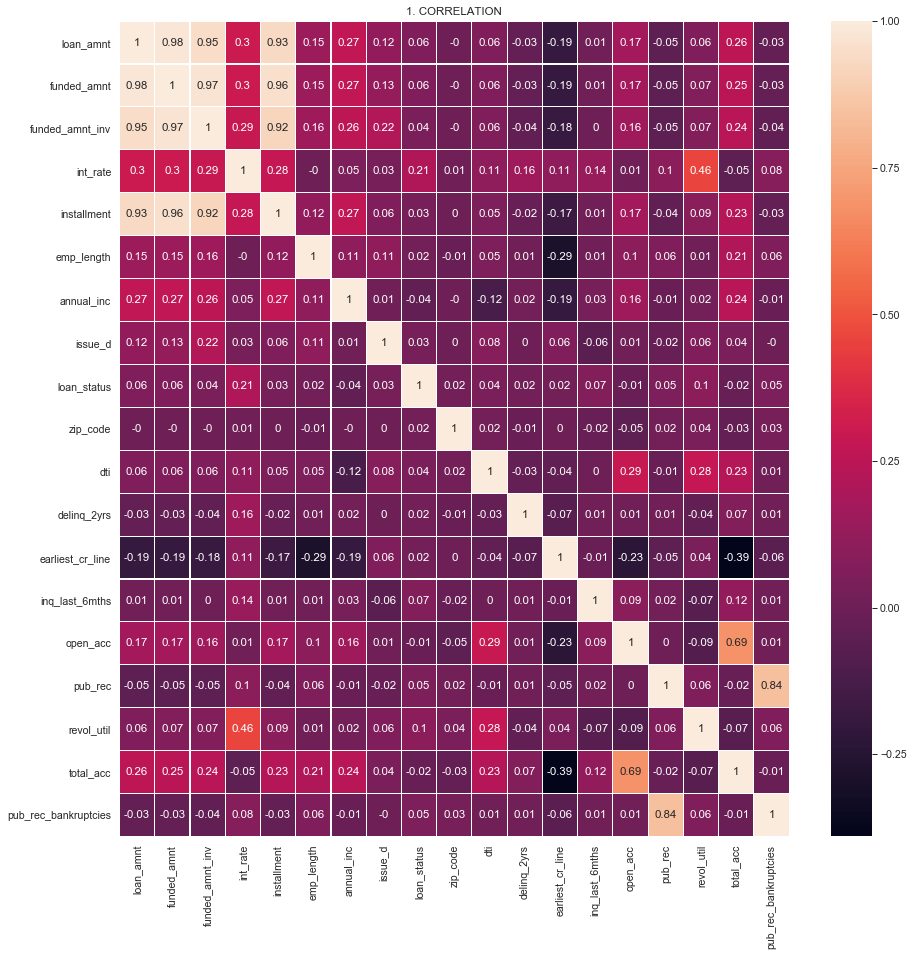

In [25]:
#Checking for correlated columns
plot_graph(1,1,1,plot.heatmap,'Correlation',loan,width=15,height=15)
plt.show()

*One can easily analyze from the above heatmap that there are a few columns which are highly correlated to each other. One can easily drop either of the correlated columns before proceeding with analysis as any analysis on these columns will be redundant. Below are the correlated columns.*
* *loan_amnt & installment : installment can be dropped instead loan_amnt be used for analysis*
* *loan_amnt & funded_amnt : funded_amnt can be dropped instead loan_amnt be used for analysis*
* *loan_amnt & funded_amnt_inv : funded_amnt_inv can be dropped instead loan_amnt be used for analysis*
* *pub_rec & pub_rec_bankruptcies : pub_rec_bankruptcies can be dropped instead pub_rec be used for analysis*
* *open_acc & total_acc : total_acc can be dropped instead open_acc be used for analysis*

In [26]:
#Removing the correlated columns
columns_to_drop=['installment','funded_amnt','funded_amnt_inv','pub_rec_bankruptcies','total_acc']
loan=drop_columns(loan,columns_to_drop)
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36800 entries, 0 to 39680
Data columns (total 20 columns):
loan_amnt              36800 non-null int64
term                   36800 non-null object
int_rate               36800 non-null float64
grade                  36800 non-null object
sub_grade              36800 non-null object
emp_length             36800 non-null int64
home_ownership         36800 non-null object
annual_inc             36800 non-null float64
verification_status    36800 non-null object
issue_d                36800 non-null int64
loan_status            36800 non-null int64
purpose                36800 non-null object
zip_code               36800 non-null int64
dti                    36800 non-null float64
delinq_2yrs            36800 non-null int64
earliest_cr_line       36800 non-null int64
inq_last_6mths         36800 non-null int64
open_acc               36800 non-null int64
pub_rec                36800 non-null int64
revol_util             36800 non-null float

#### 4.2 Univariate  & Segmented Univariate Analysis

In [27]:
loan.describe()

,loan_amnt,int_rate,emp_length,annual_inc,issue_d,loan_status,zip_code,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_util
count,36800.00,36800.00,36800.00,36800.00,36800.00,36800.00,36800.00,36800.00,36800.00,36800.00,36800.00,36800.00,36800.00,36800.00
mean,11149.54,11.98,5.08,69434.48,2010.35,0.14,503.05,13.33,0.15,1996.76,0.87,9.30,0.05,48.99
std,7369.86,3.70,3.40,64021.59,0.82,0.35,330.08,6.65,0.49,6.63,1.07,4.38,0.24,28.31
min,500.00,5.42,1.00,4000.00,2007.00,0.00,7.00,0.00,0.00,1946.00,0.00,2.00,0.00,0.00
25%,5500.00,8.94,2.00,41133.00,2010.00,0.00,200.00,8.22,0.00,1994.00,0.00,6.00,0.00,25.60
50%,10000.00,11.83,4.00,60000.00,2011.00,0.00,450.00,13.43,0.00,1998.00,1.00,9.00,0.00,49.50
75%,15000.00,14.46,9.00,83000.00,2011.00,0.00,852.00,18.59,0.00,2001.00,1.00,12.00,0.00,72.50
max,35000.00,24.40,10.00,6000000.00,2011.00,1.00,999.00,29.99,11.00,2008.00,8.00,44.00,4.00,99.90


*Univariate analysis plots on the left hand side and segmented univariate analysis for the same parameter on the right hand side are given below*

Univariate Analysis                                                    Segmented Univariate Analysis


C:\Users\vpgurura\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


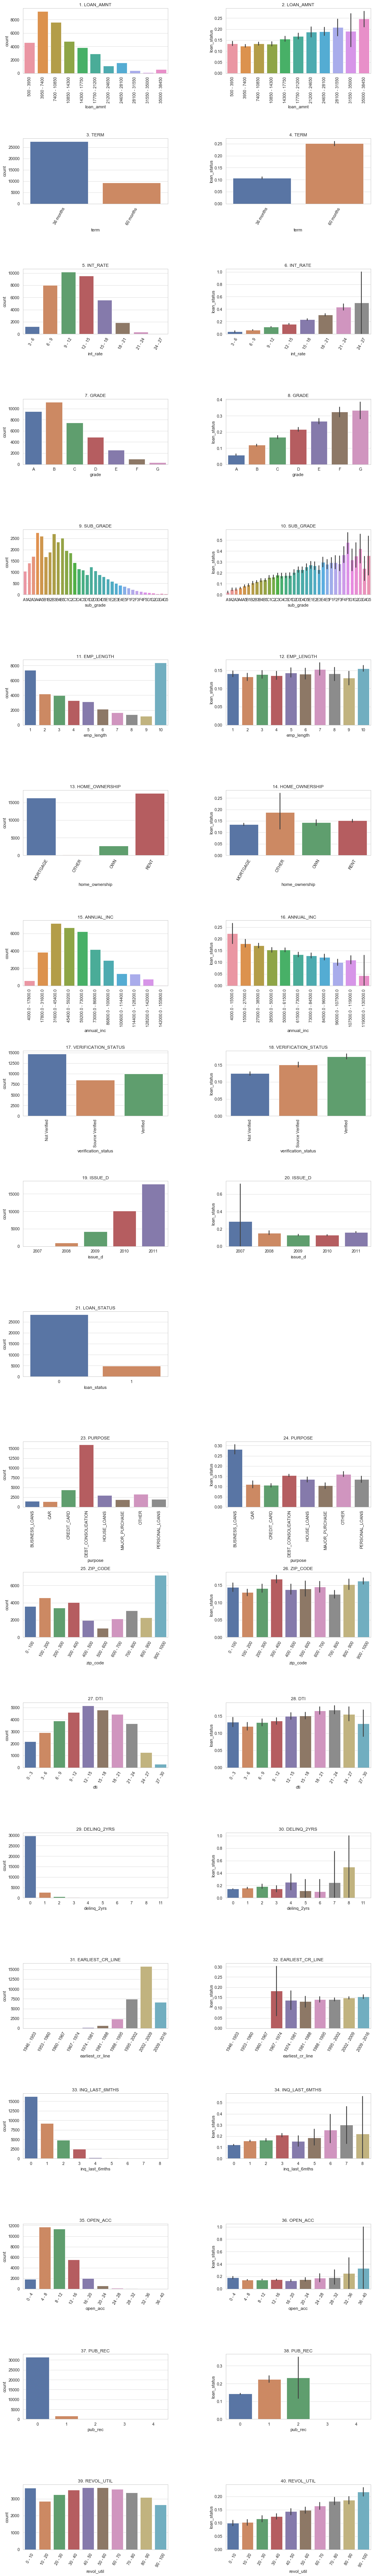

In [28]:
#Univariate and Segmented Univariate analysis of the quantitative/categorical variables
print('Univariate Analysis',' '*50,'Segmented Univariate Analysis')
print('='*120)
columns_for_analysis=[]
for col,value in {col:len(loan[col].unique()) for col in loan.columns}.items():
    quantile=0
    span=10
    if col=='sub_grade':
        columns_for_analysis.append([plot.count,False,span,0,'sub_grade',None,None])
        columns_for_analysis.append([plot.bar,False,span,0,'sub_grade','loan_status',None])    
    else:
        if col=='annual_inc':
            quantile=0.05
        columns_for_analysis.append([plot.count,True if value>20 else False,span,quantile,col,None,None])
        columns_for_analysis.append([plot.bar,True if value>20 else False,span,quantile,col,'loan_status',None])

draw_multiple_plots(2,loan,columns_for_analysis)
plt.show()

**Analysis form the above table and univariate plots**

1. **Loan Amount : Most of the loans approved are of amounts varying between 500 to 21000 with the numbers decreasing for increase in loan amounts. The rate of default increases from around the 12% mark for the loan amounts below 7500 to almost 25% for loan amounts above 35000.**

2. **Term : The number of loans approved for short term (36 months) is almost thrice that of the long term (60 months). The default rate is pretty high almost 25% for long term loans as compared to 10% for short term loans.**

3. **Interest Rate : The rate of interest for most of the loans approved lies between 6% to 18%. The rate of default increases steadily with the increase in the rate of interest starting from almost 2% for interest rates of 3% to almost 50% for interest rates of 24% and above.**

4. **Grade : A major chunk of the loans approved belong to Grades A, B, C & D with the numbers decreasing at a significant rate as the grade increases. The default rate keeps increasing significantly with the grades starting with 6% for grade A to 32% for grade G.**

5. *Sub-Grade : The number of loans approved shows an increasing trend till subgrade C1 and then a decreasing trend from thereon. This is evident as one can see the rate of default rising uniformly from almost 2% for A1 to almost 35% for subgrades in F & G. The rate of default is almost 15% for the subgrade C1 which is almost equivalent to the 14% overall default rate, implying the decrease in the number of loans approved above subgrade C1.*

6. **Years of Employment : People with employment length of 1 year or less and 10 years or more have the highest number of approvals for the loans.** *The default rate is pretty much uniform between 13% to 15% across all the length of employment.*

7. *Home Ownership : Almost 95% of loans being approved are to the people with a mortgaged or rented house. The default rate is pretty much uniform between 13% to 15% for Mortgaged, Owned and Rented ownership. Though the number of loans approved for the others (borrowers whose house ownership has not been identified) is very low default rate is almost 19% for this segment.*

8. **Annual Income : Almost all of the loans approved have an annual income range of 4,000 to 1,50,000. The rate of default decreases steadily from almost 22% for applicants having annual income of 15,000 or less to 5% for applicants with annual incomes of 1,19,000 or more.**

9. **Income Verification Status : Almost 40% of the loans approved do not have their income sources verified. But alarmingly the default rate for un-verified income sources have a lower default rate almost 12.5% as compared to 16.5% for income source verified by LC.**

10. **Issued Date : The number of loans being funded has been skyrocketing starting with just 7 in 2007 to 4699 in 2009 to 19794 loans in the year 2011.** *The default rate has remained uniform between 12% to 15% throughout barring the first of operation which had 2 defaulted loans (28%) out of 7 loans approved.*

11. **Loan Status : The overall default rate is 14% (5000 loans) out of the total of 36800 loans approved**

12. **Loan Purpose : Almost 40% of the loans being approved is being used for Debt Consolidations, followed by Credit Card payment and Other purposes. The default rate varies between 10% to 16% for all the purposes except for Small Businesses which has is pretty high default rate of almost 27%.**

13. **ZIP Code : Most of the loans being approved are from the areas with zip codes in the range of 100xx to 300xx and 900xx.** *The default rate hovers around 14% for all the areas.*

14. **DTI ratio : The number of loans being approved increases uniformly for dbi ratios 0% to 15% and then decreases sharply thereafter till 30%. The rate of default shows an increasing trend for the DTI ratio starting from almost 11% for ratios below 6% to almost 16% for ratios upto 24%,  but then rate of default decreases uniformly to 12% for ratios above 24% till 30%.**

15. *Delinquency in last 2 years : Almost all of the loans being approved do not have any past incidences of delinquency in the last 2 years. The default rate is almost 15% for the applicants with no instances of delinquency in the past 2 years.**

16. *Earliest Credit Line : Most of the loans approved had their credit lines starting around the 2000's. The rate of default remains almost same around 14% irrespective of the applicants start date of credit lines.*

17. **Inquiry for Loans in past 6 months : Most of the loans approved were for the applicants who had inquired not more than thrice for a loan in the past 6 months. The default rate increases with the increase in the number of inquiries for loan made in the past 6 months for around 11% with no enquiries to 20% with enquiries for three or more times.**

18. *Open Accounts : Applicants having at least 1 to 15 open accounts on their names have the most loans approved. The rate of default remains the same around almost 13% for applicants having less than 25 open accounts on their names, but increases to around 30% with the increase in the number of open accounts.*

19. *Derogatory Public Records : 95% of the loans approved are the applicants without any derogatory public records to their name. The rate of default is almost 14% for applicants without any public records as compared to almost 22% for applicants with a record.*

20. **Revolving line utilization rate: The number of loans being approved is uniformly distributed across the whole range of revolving utilization percentage, implying that the rate of revolving credit does not play any significant role in the approval of a loan. The rate of default increases steadily starting from almost 9% for revolving utilization below 10% to around 21% as the revolving utilization percentage increases to 100%.**

#### 4.3 Bivariate Analysis

*Looking at the Business Model of LC : 
Lending Club enables borrowers to create unsecured personal loans between 500 and 40,000 dollars. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.*

*There are many number of bivariate analysis that can be done (such as each attribute against all other attributes for the default rate). But based on the above business perspective we are going to conduct the bivariate analysis for the amount of loan, purpose of loan and loan grade against the other attributes. Below we are going to plots.*

In [29]:
#Grouping the various loan amounts into the below mentioned groups to decrease the number of categories in loan amounts
def group_loan_amounts(amount):
    if amount<=8000:
        return '0-8000'
    elif amount<=16000:
        return '8000-16000'
    elif amount<=24000:
        return '16000-24000'
    elif amount<=32000:
        return '24000-32000'
    else:
        return '32000-40000'
    
loan.loan_amnt=loan.loan_amnt.apply(lambda x:group_loan_amounts(x))
loan.loan_amnt.value_counts()

0-8000         16145
8000-16000     13311
16000-24000     4490
24000-32000     2203
32000-40000      651
Name: loan_amnt, dtype: int64

Bivariate analysis for PURPOSE


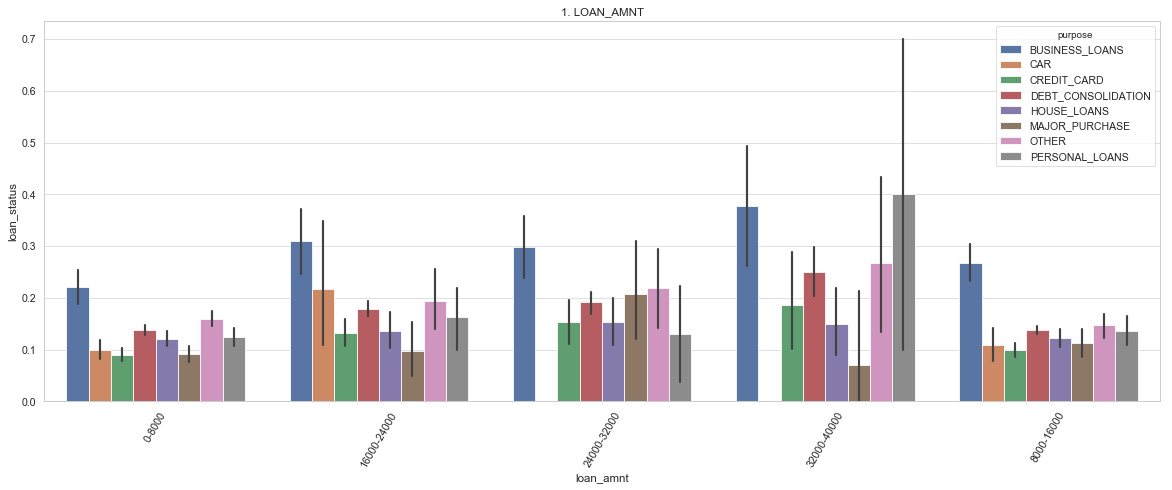

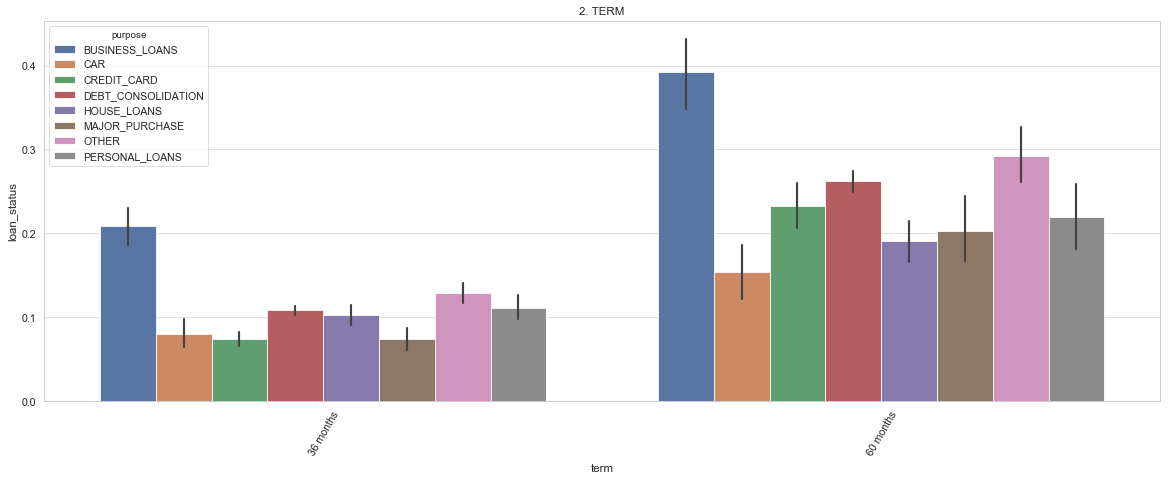

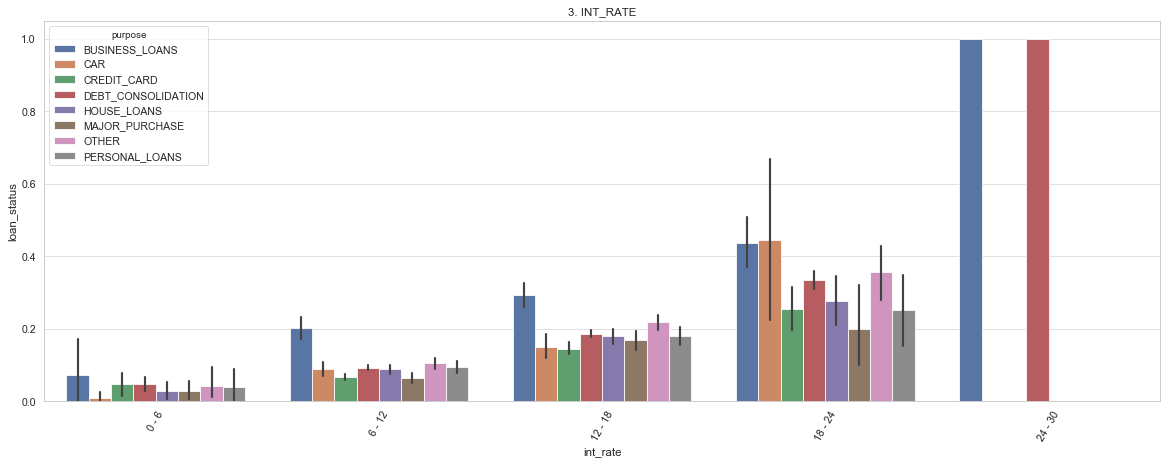

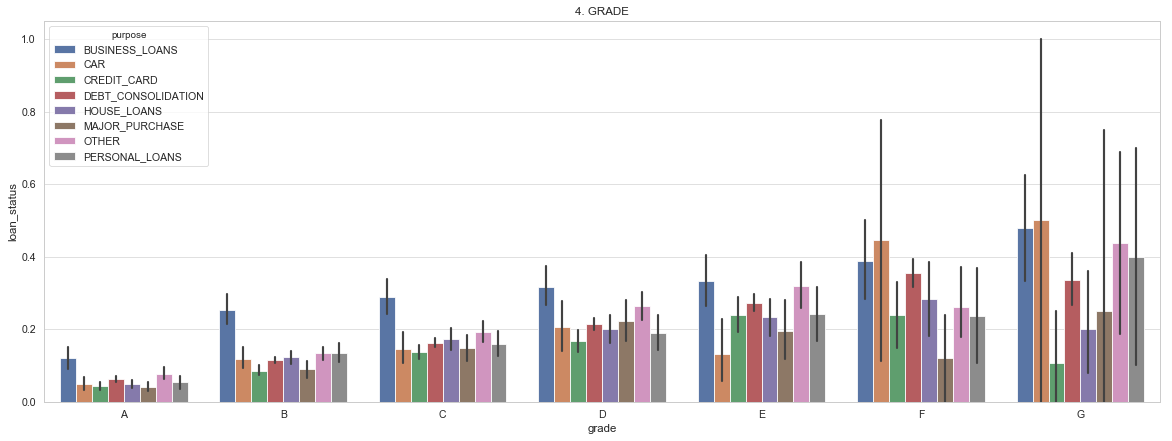

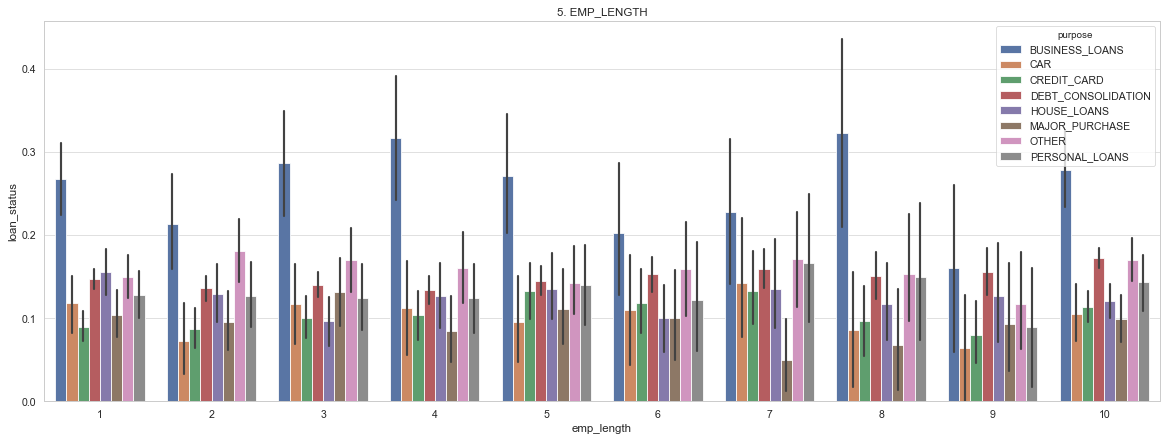

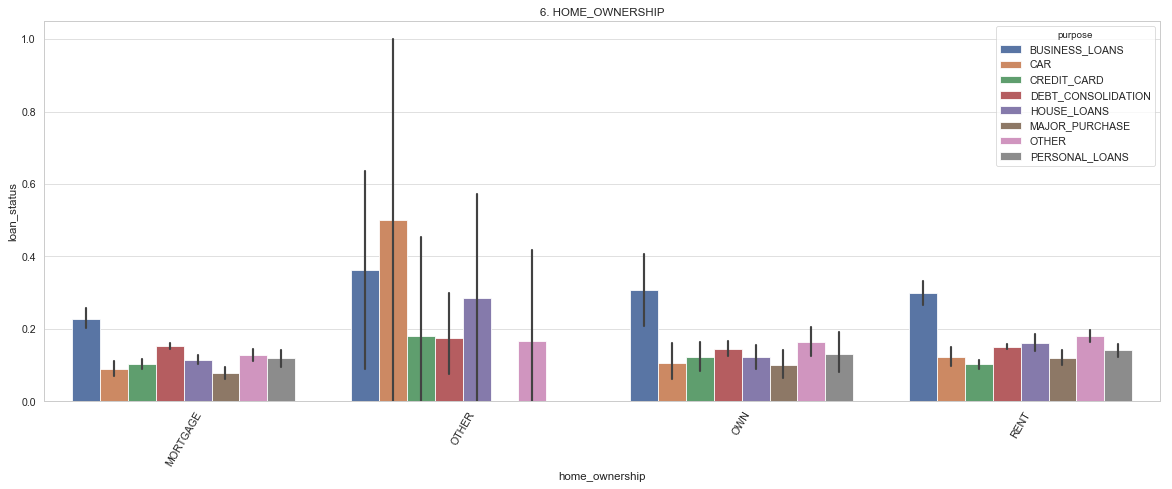

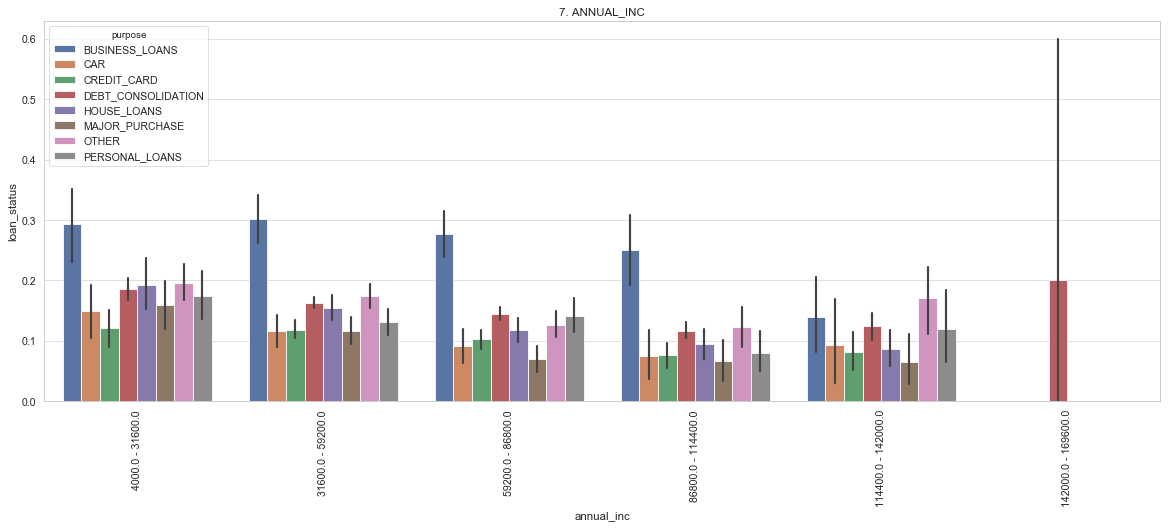

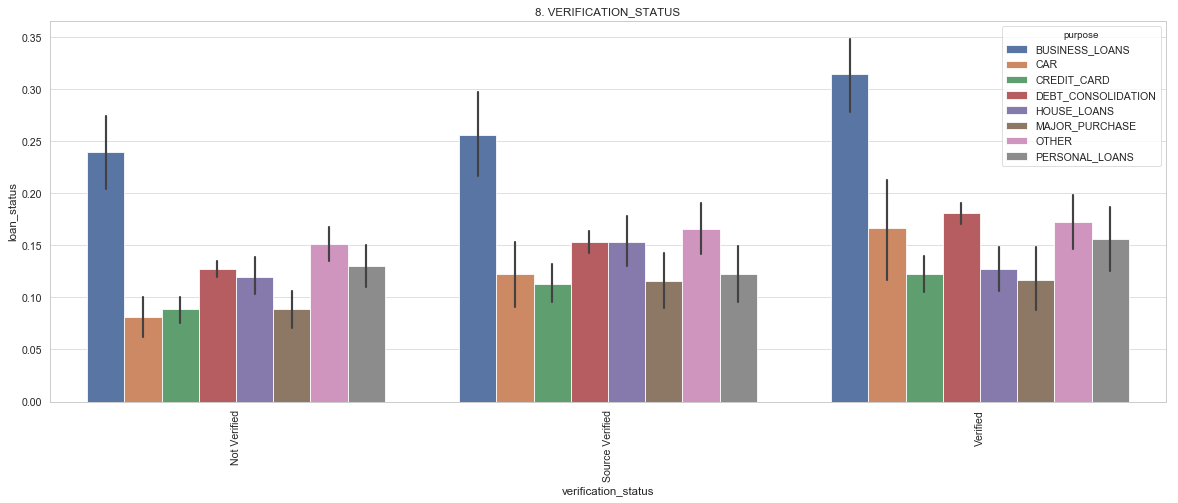

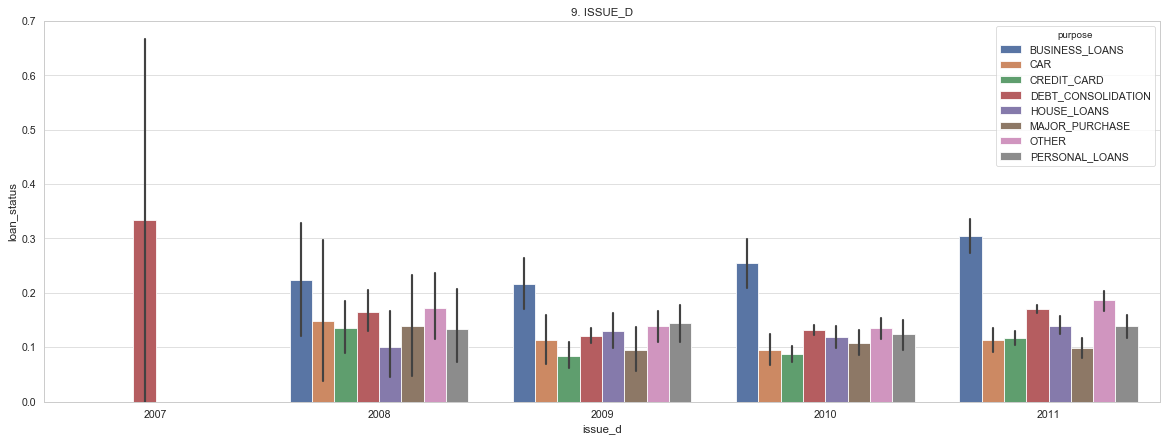

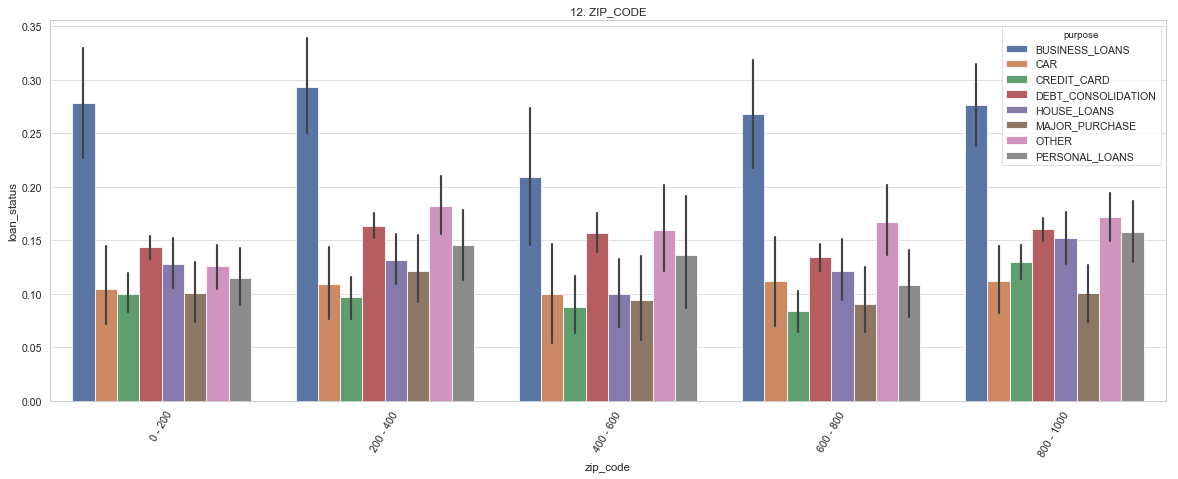

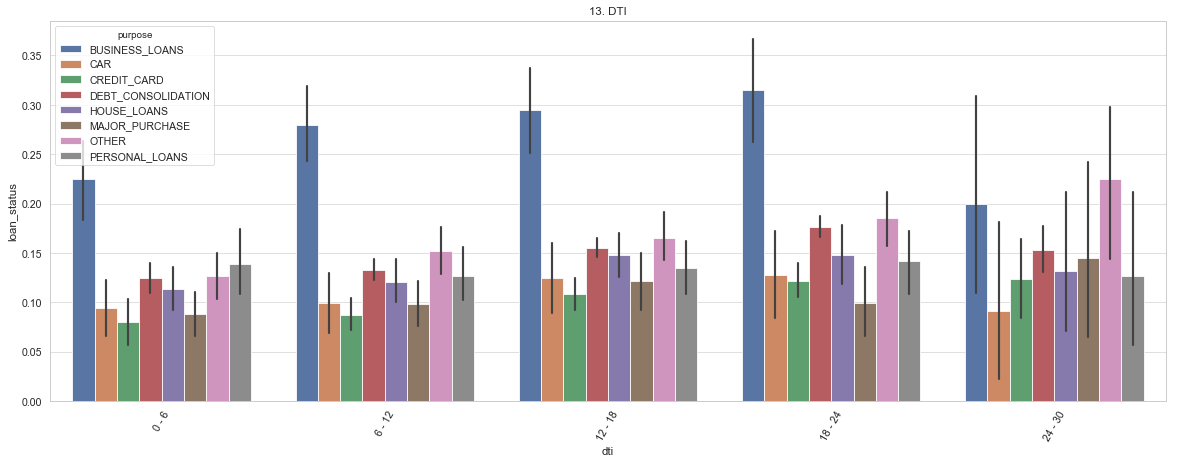

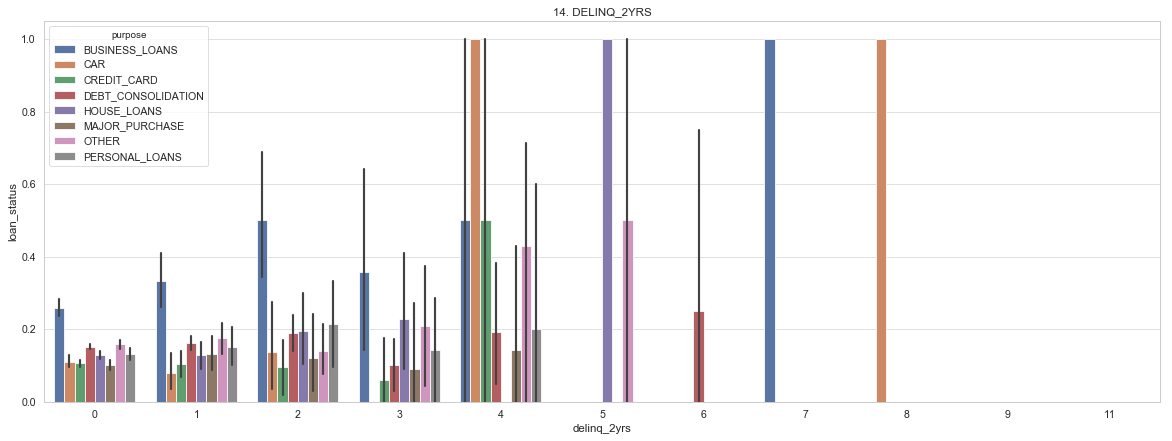

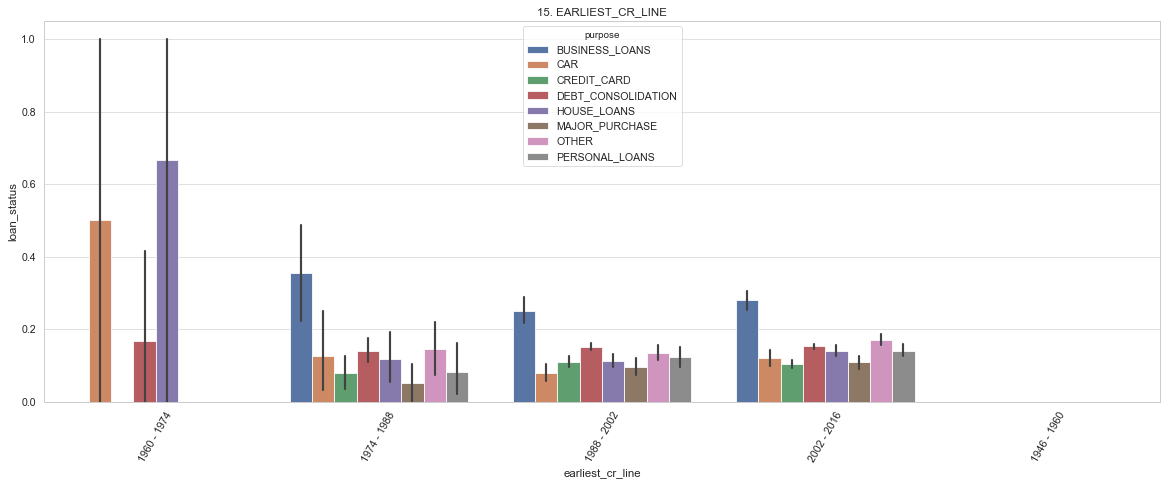

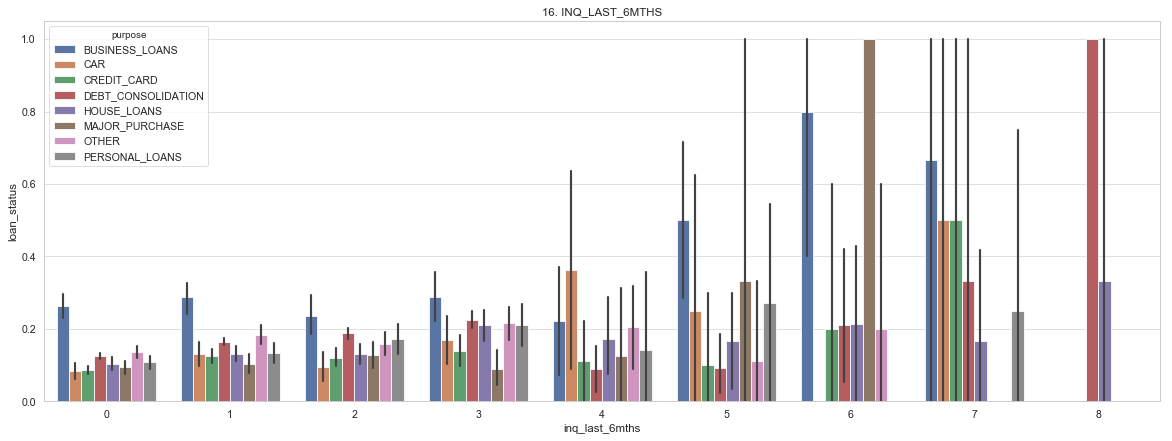

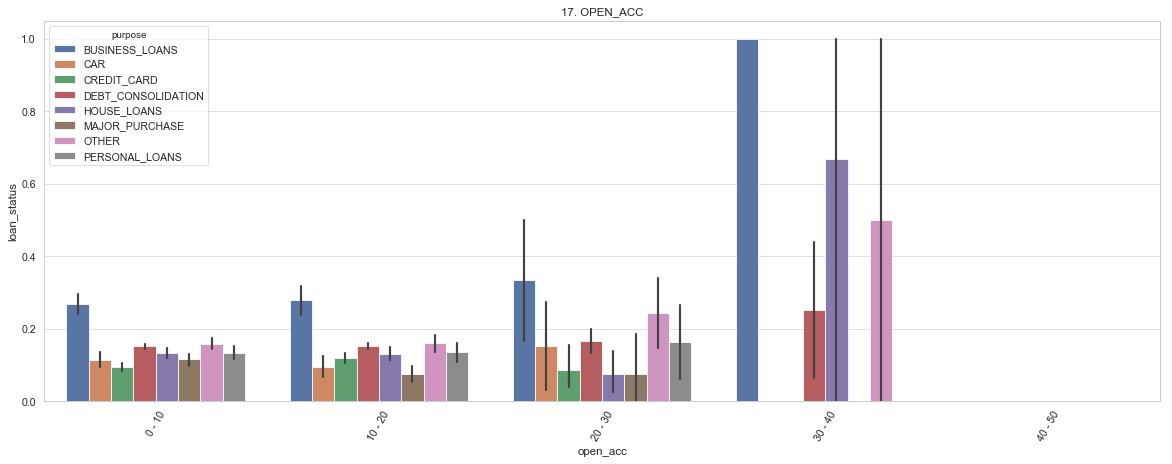

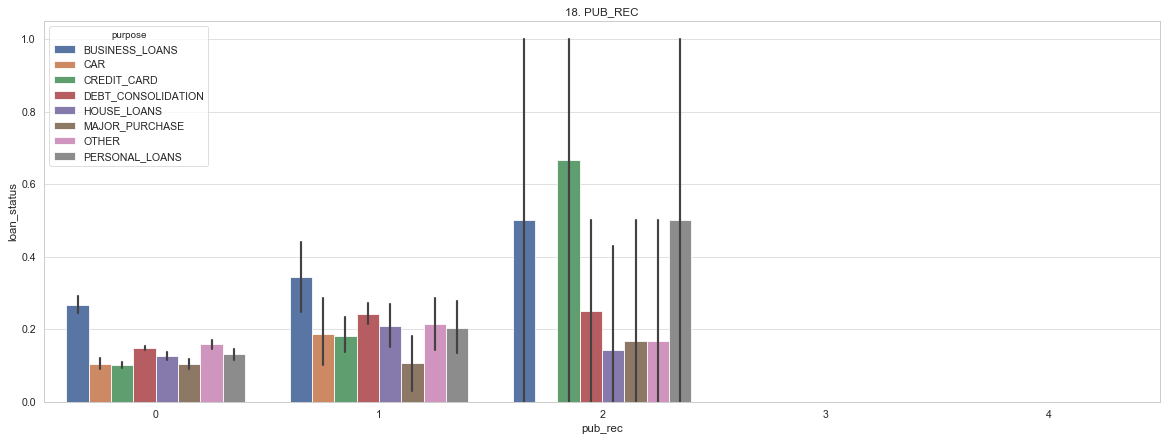

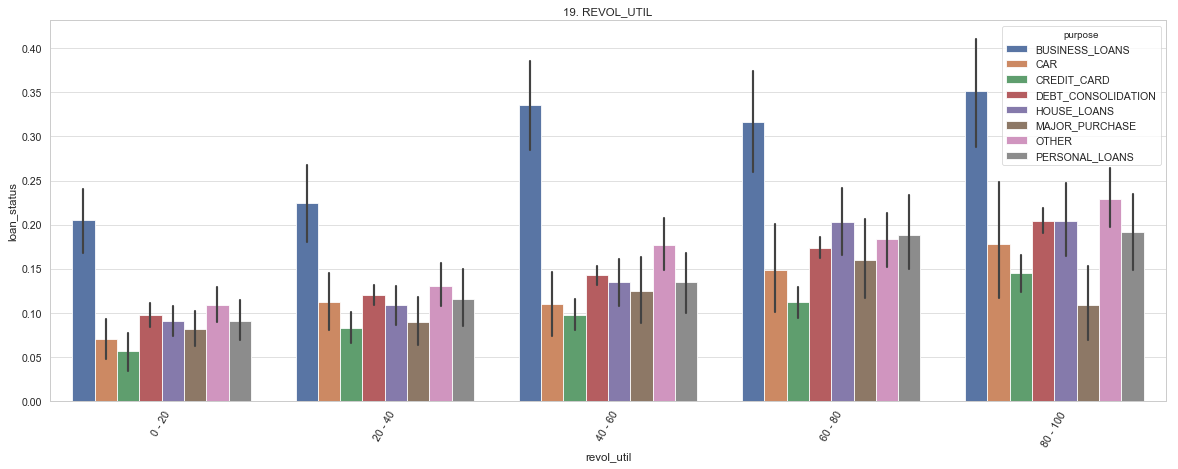

Bivariate analysis for GRADE


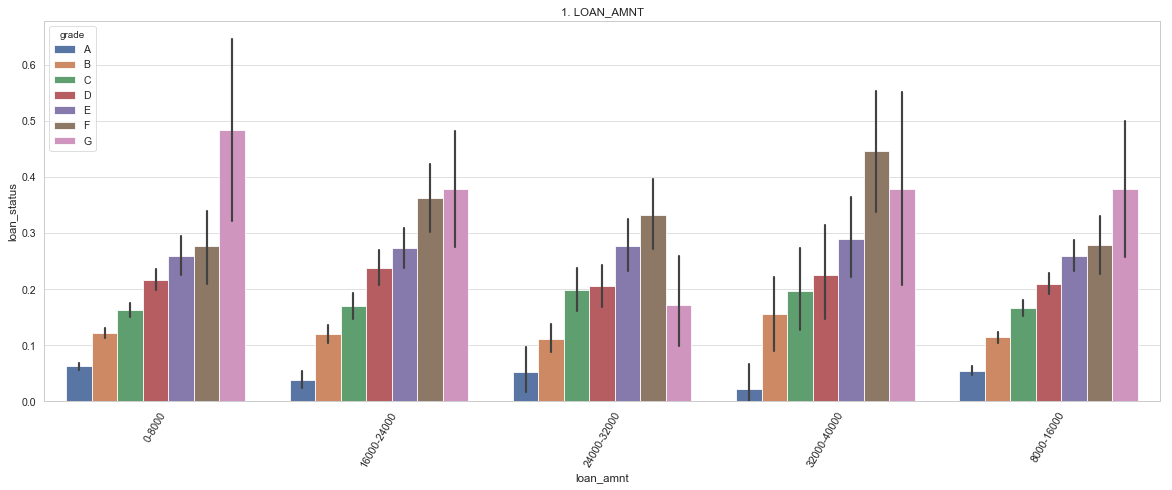

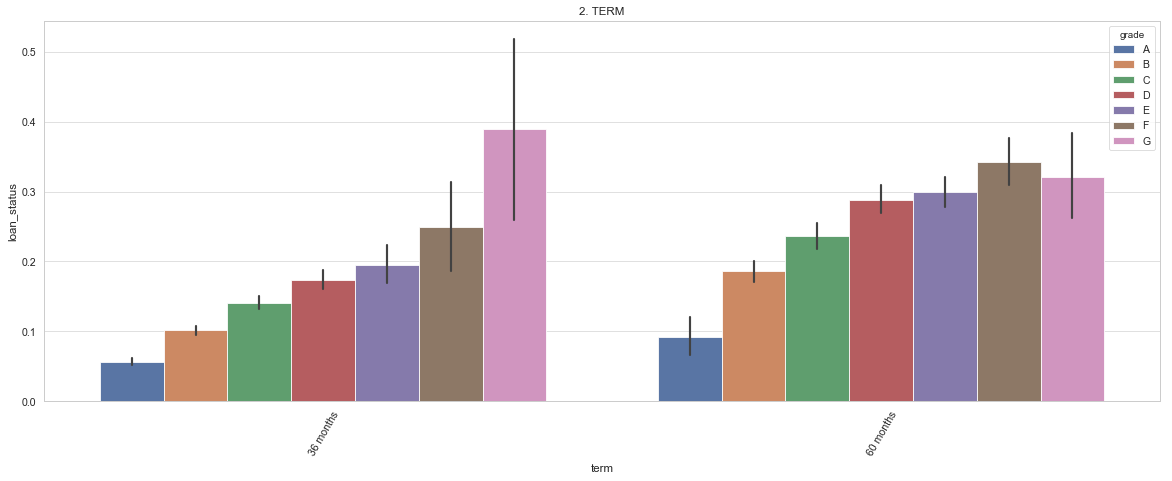

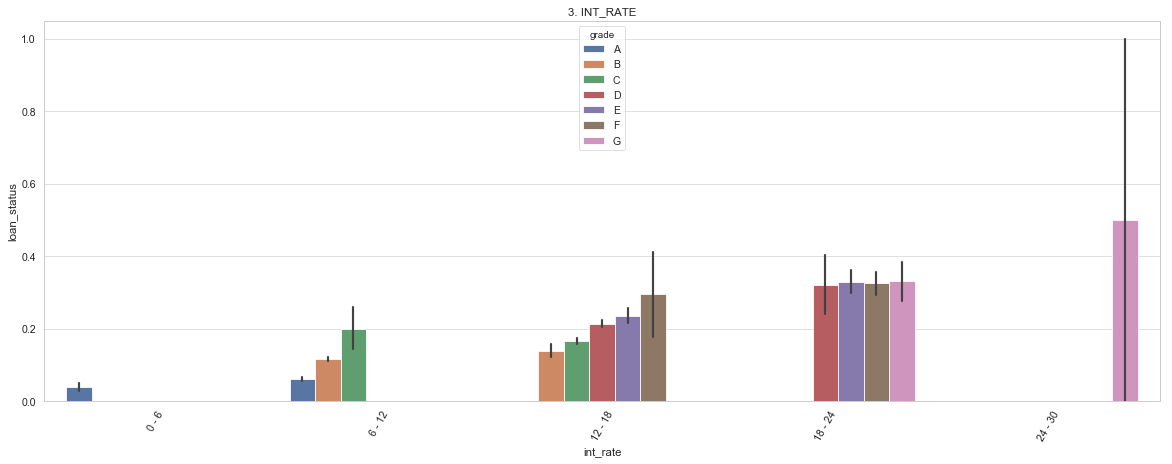

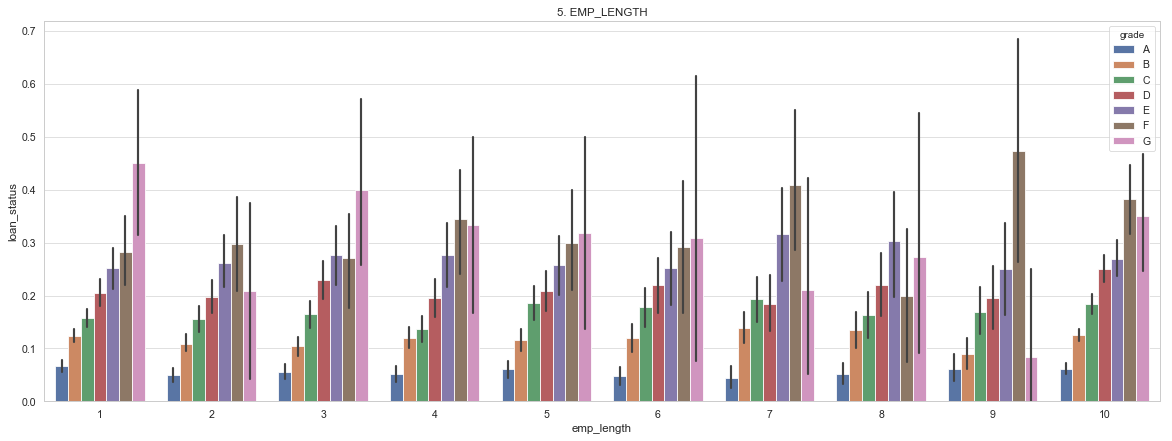

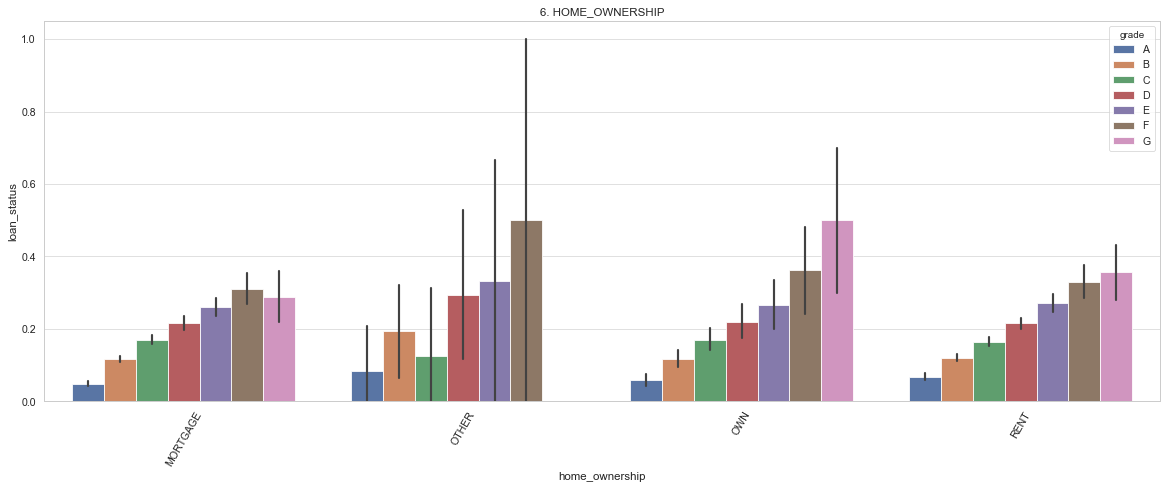

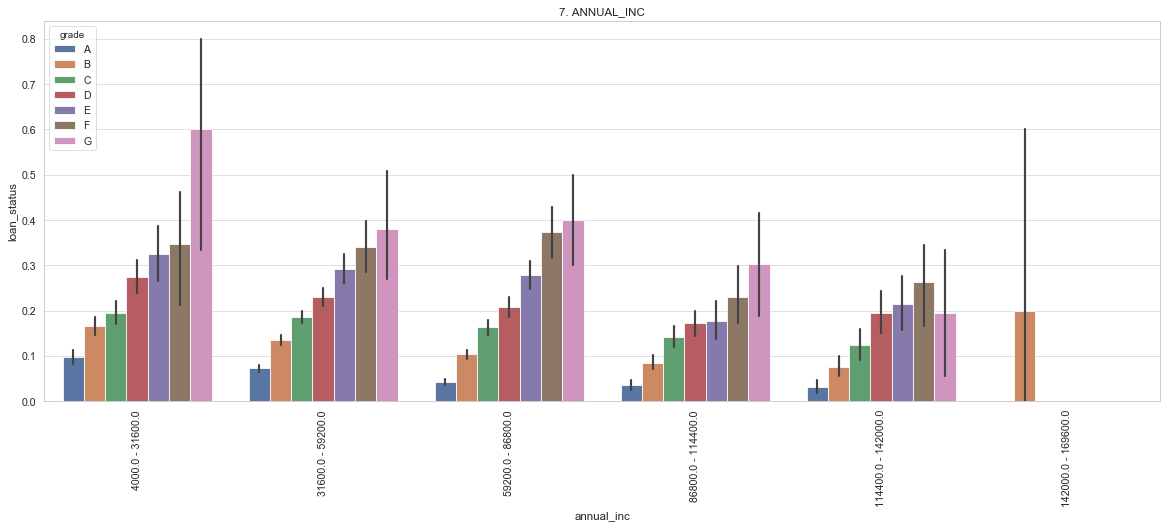

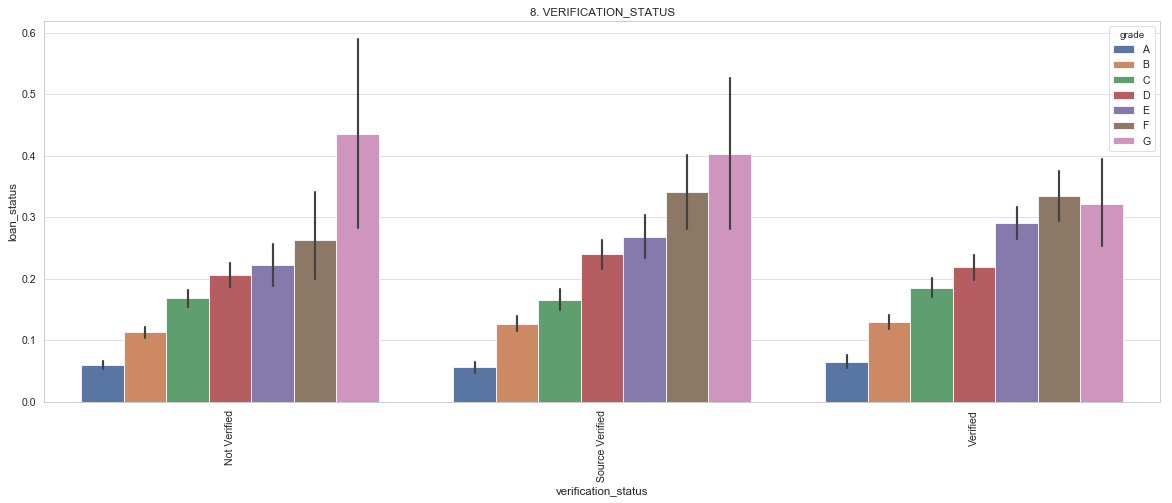

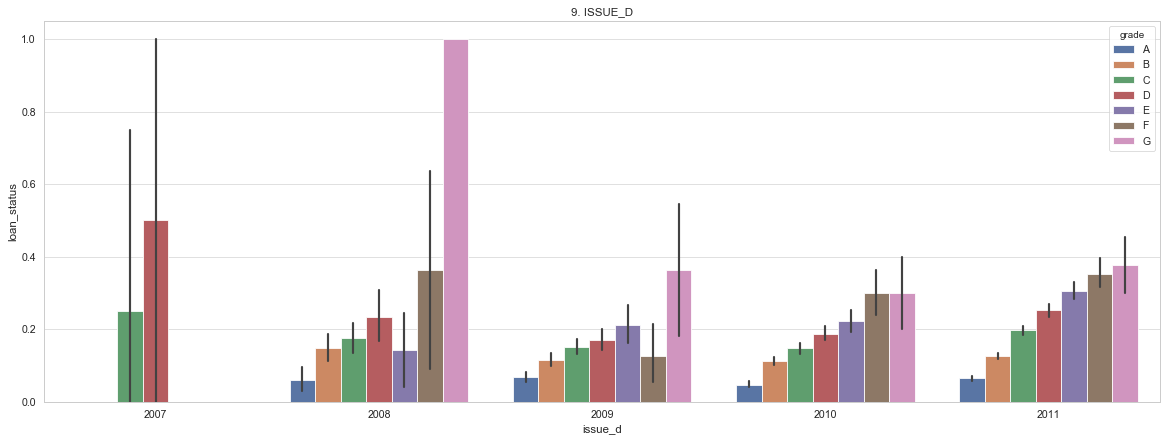

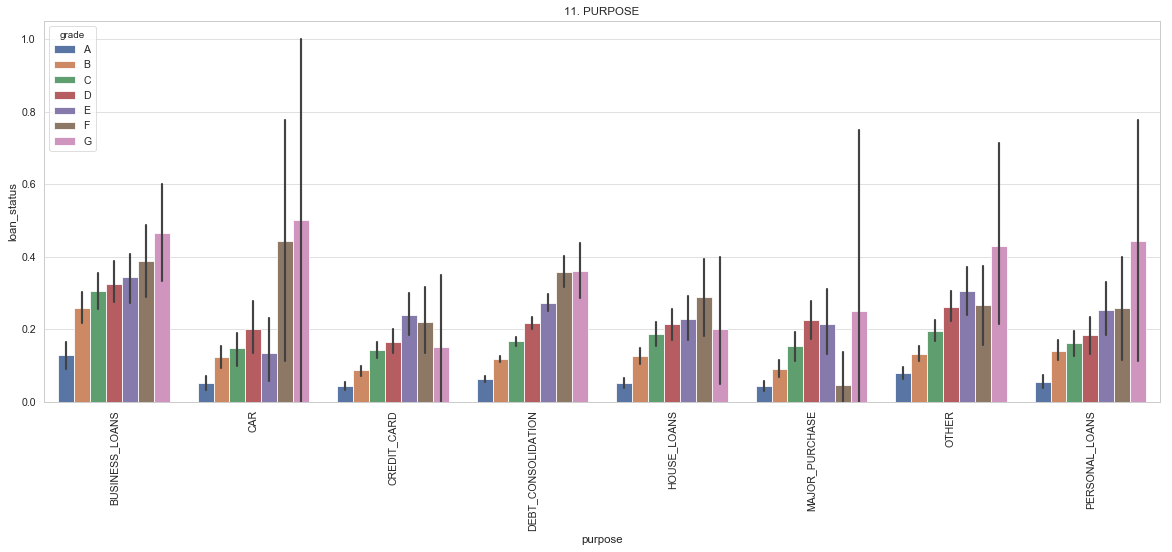

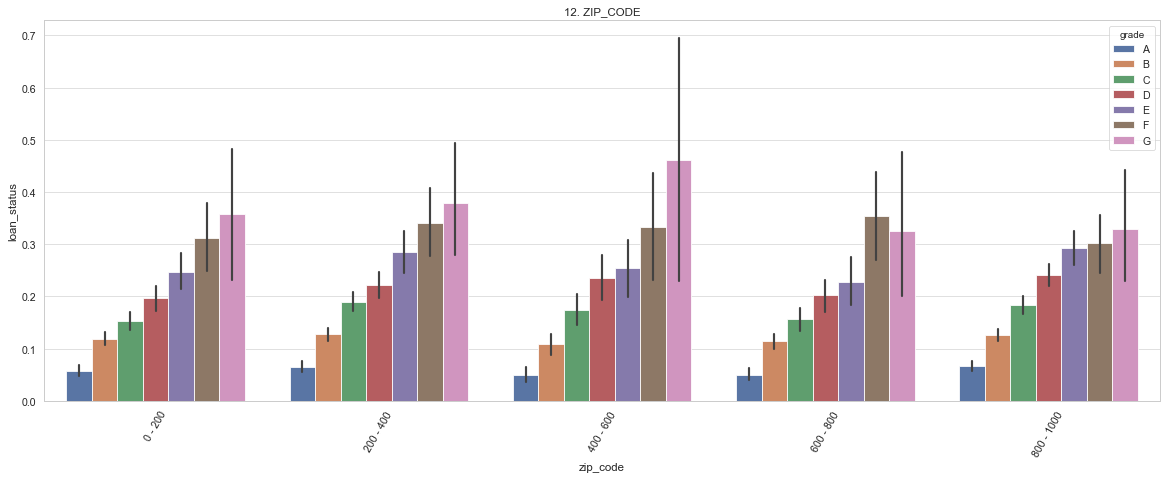

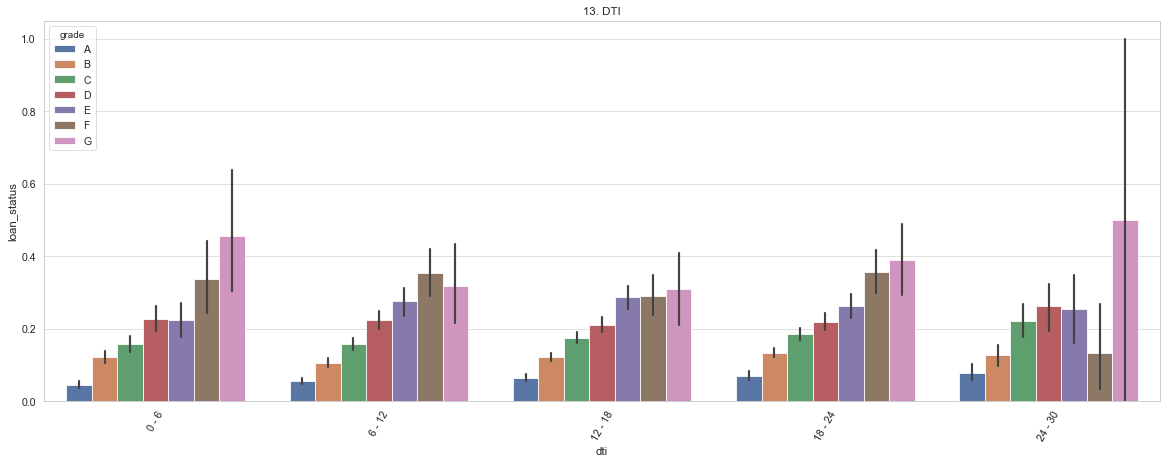

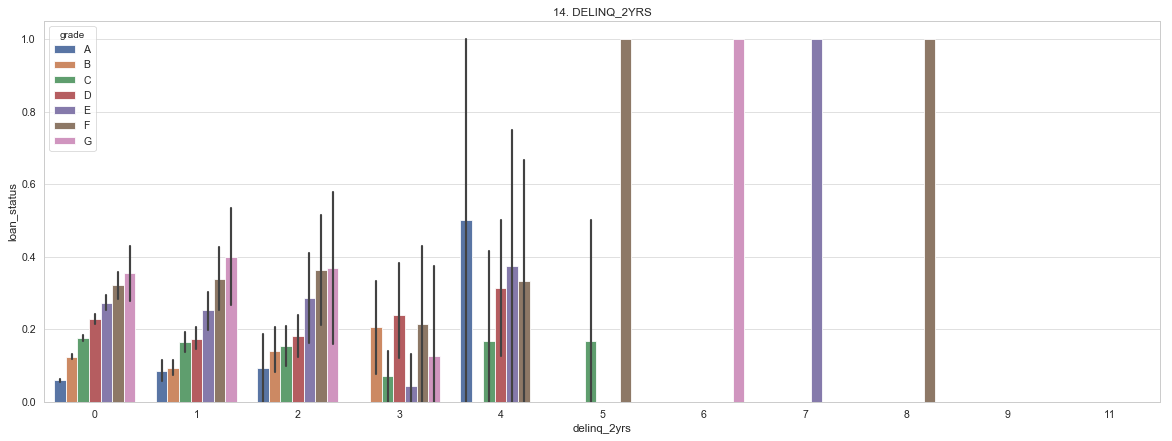

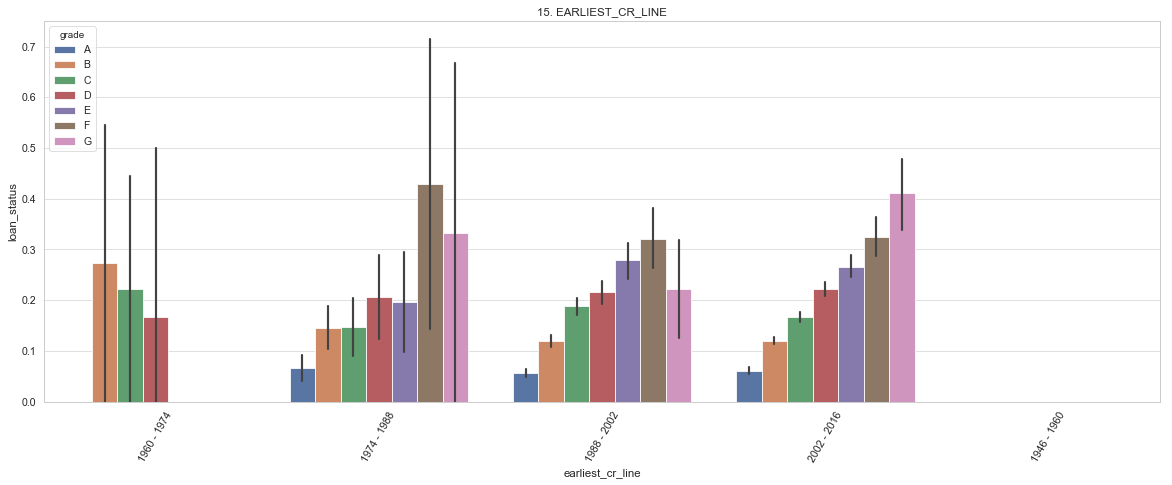

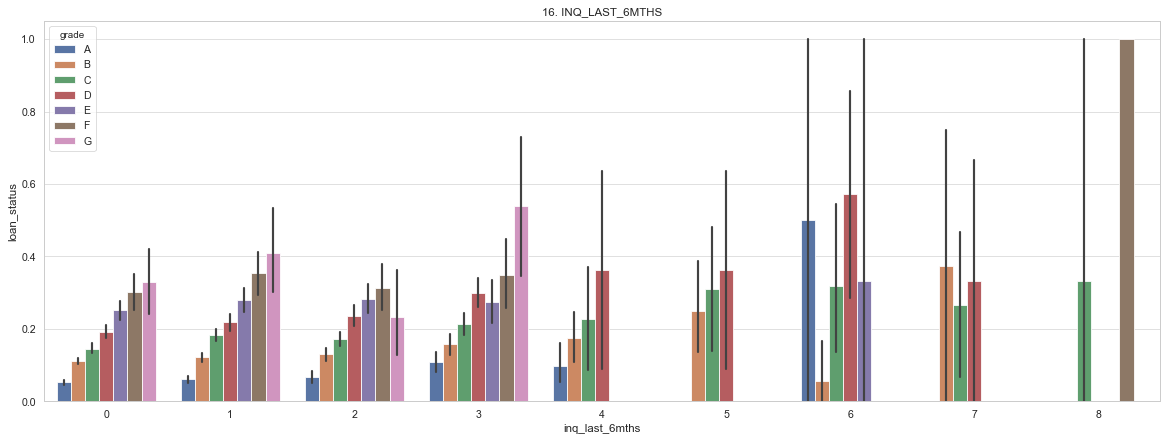

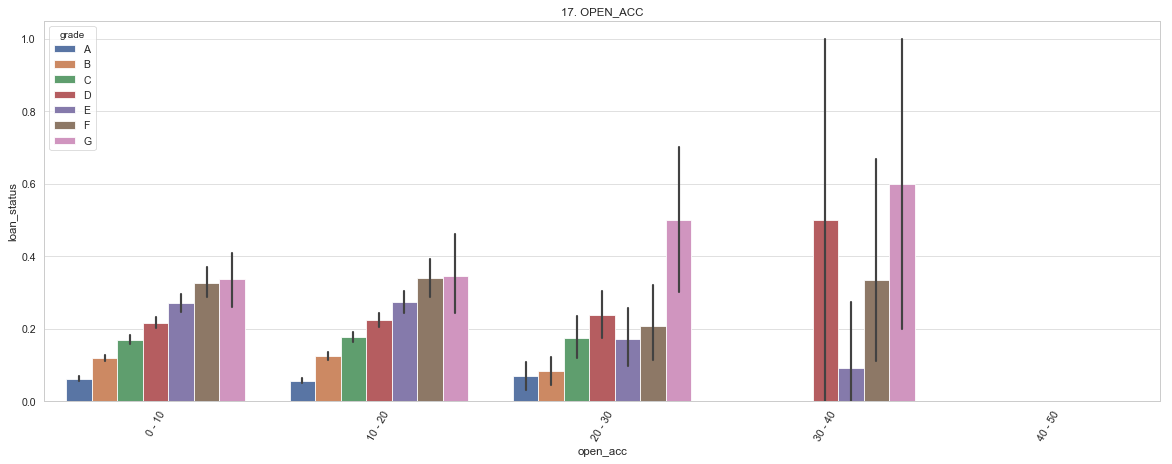

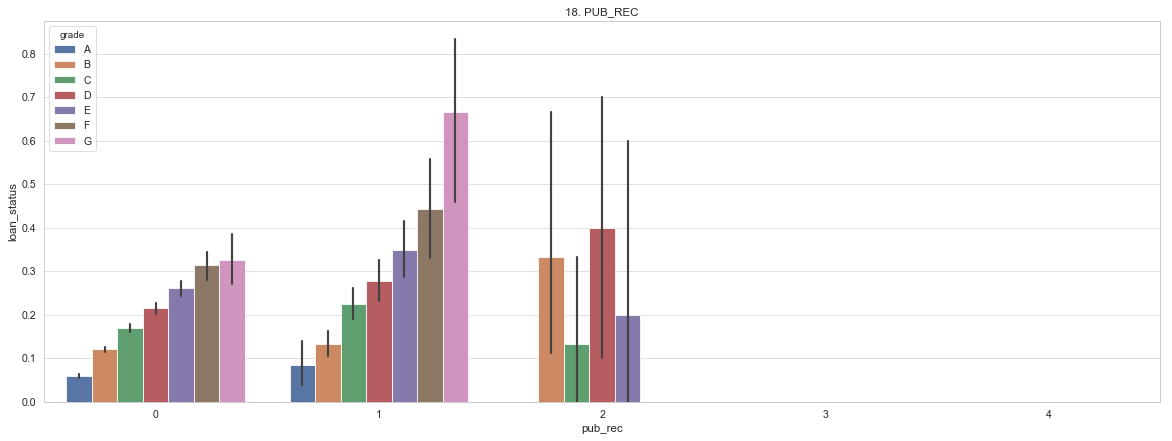

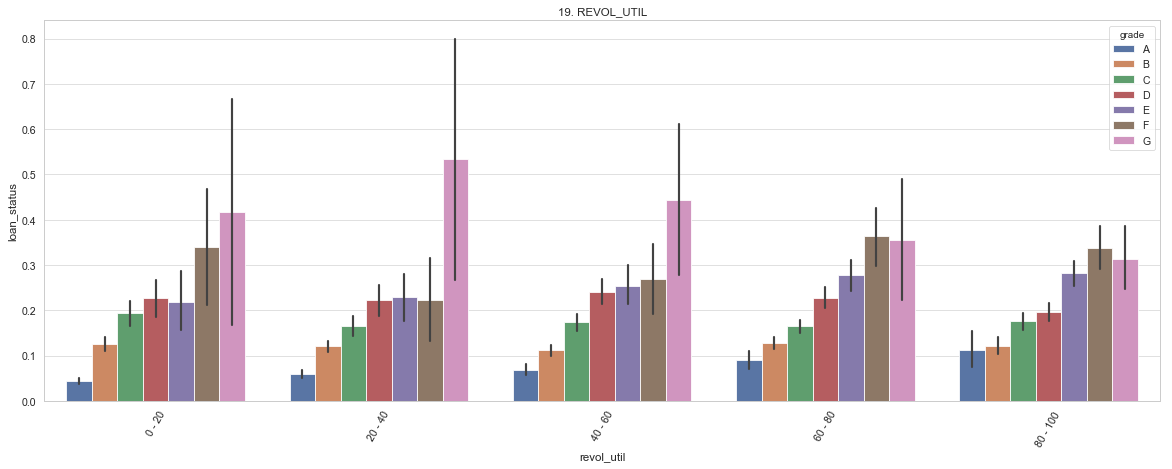

Bivariate analysis for LOAN_AMNT


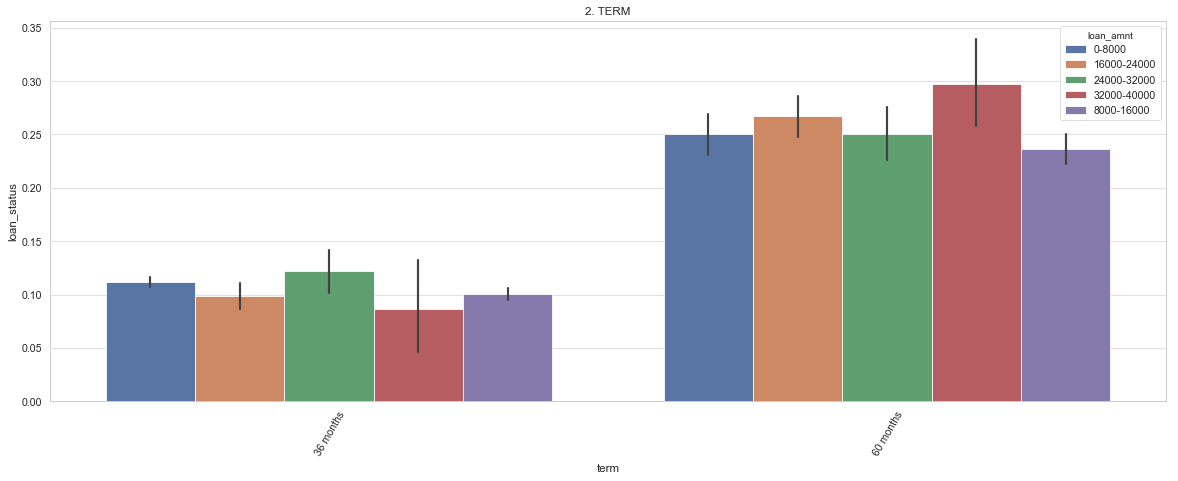

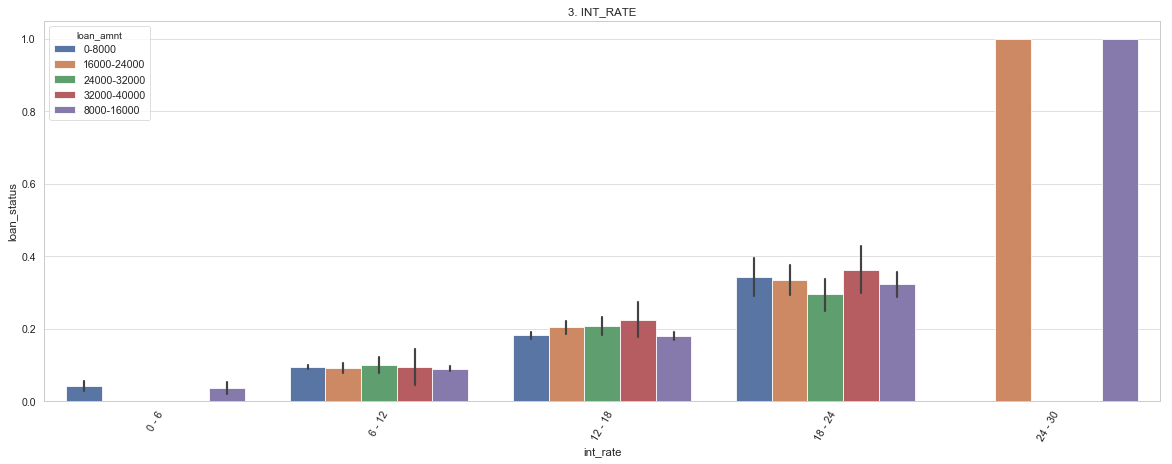

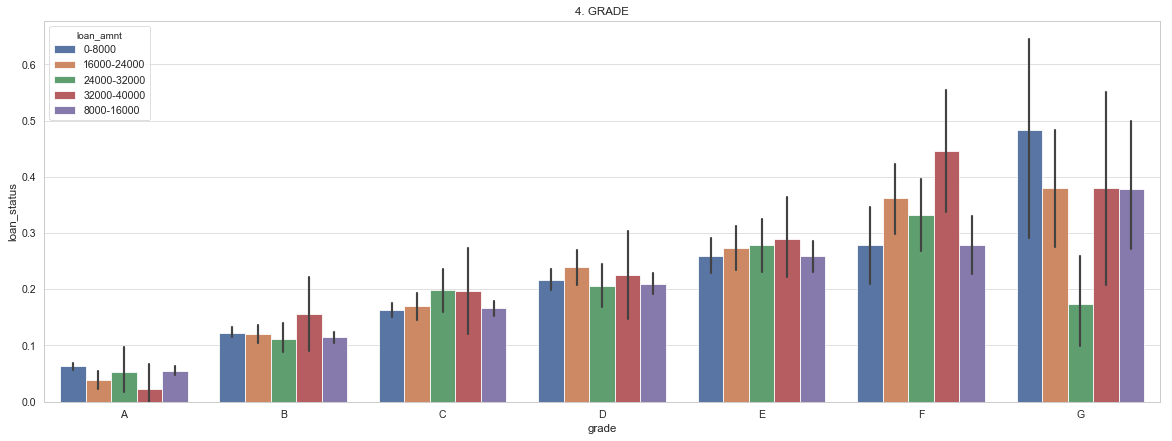

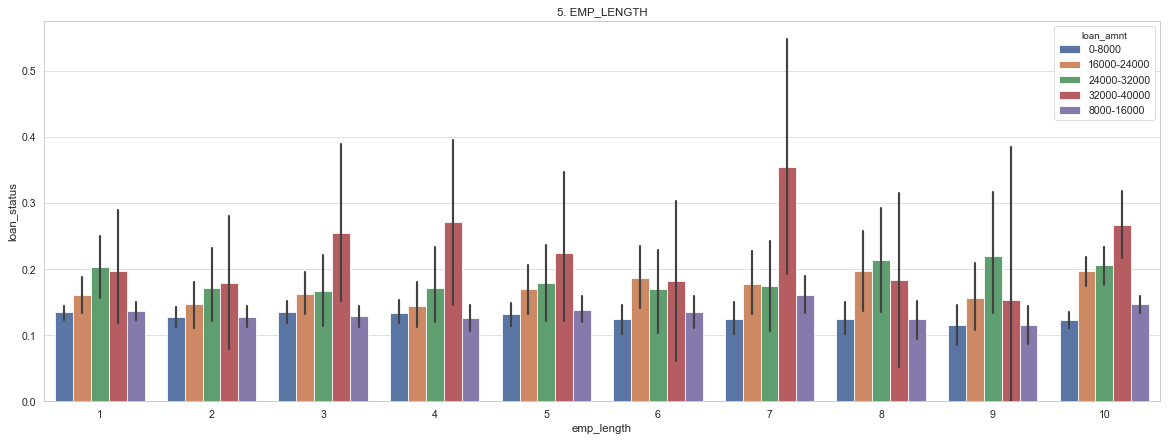

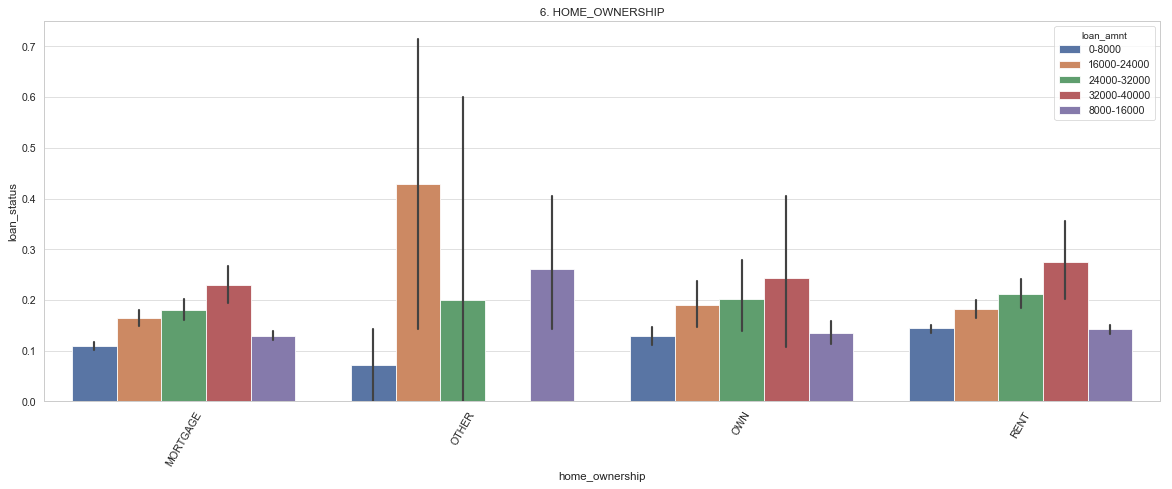

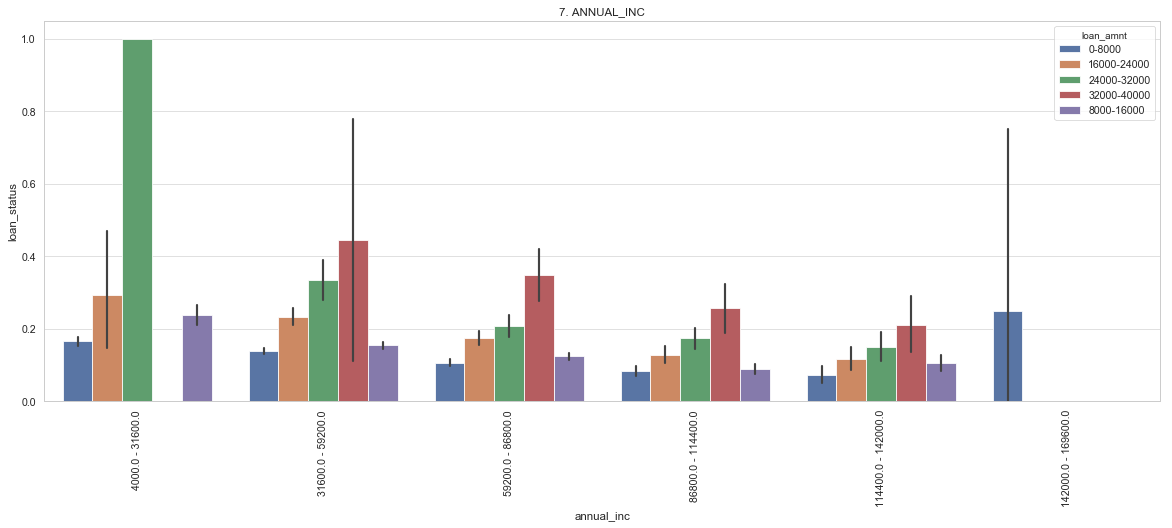

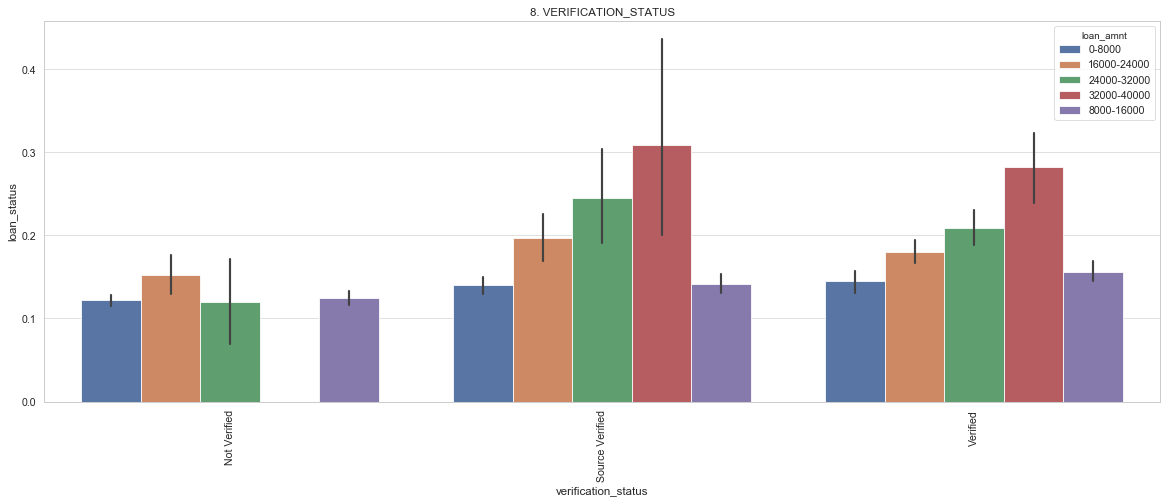

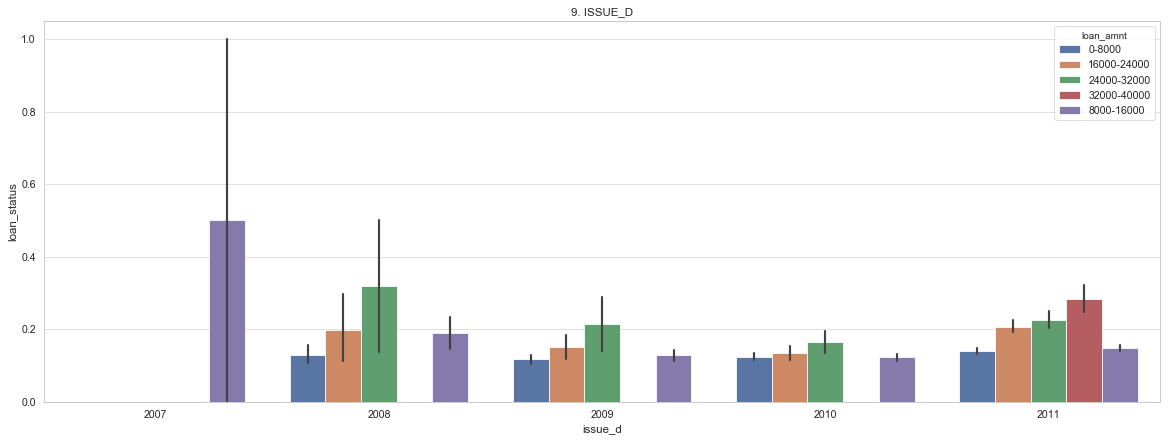

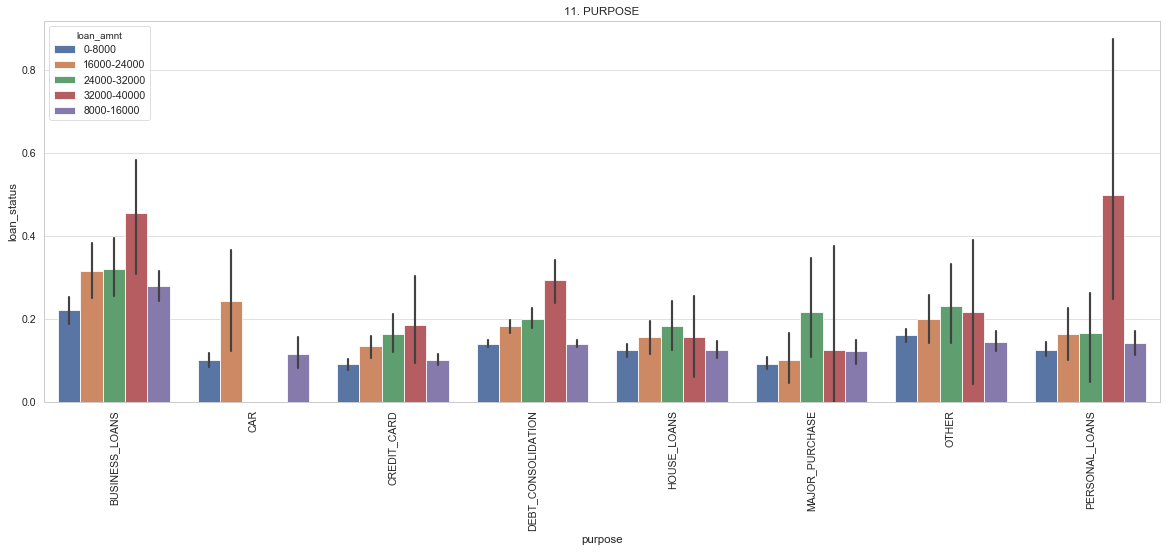

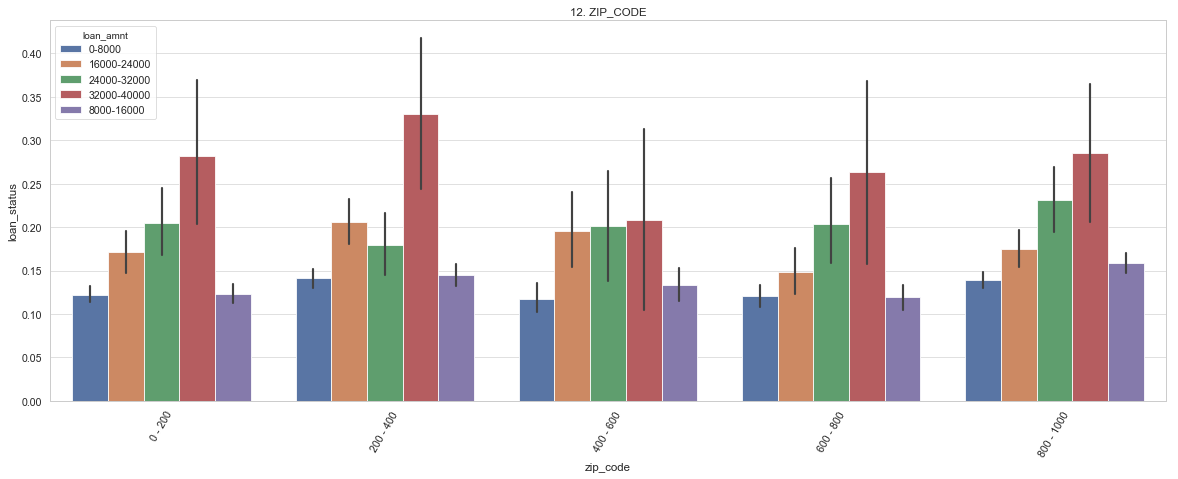

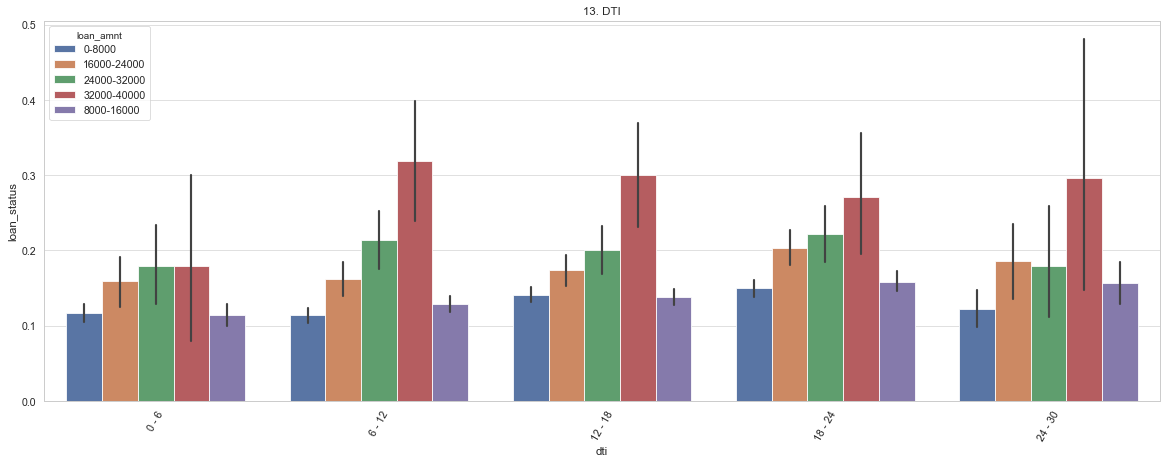

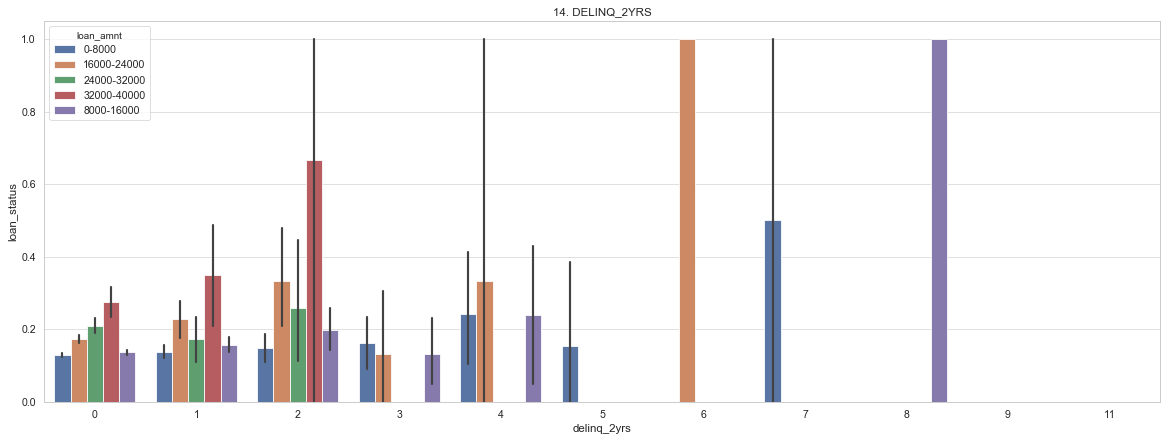

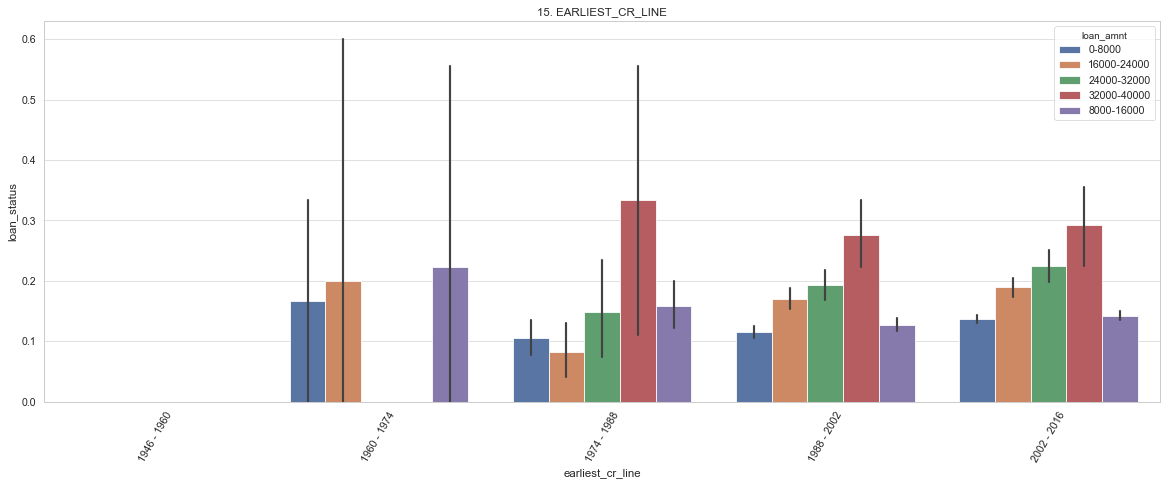

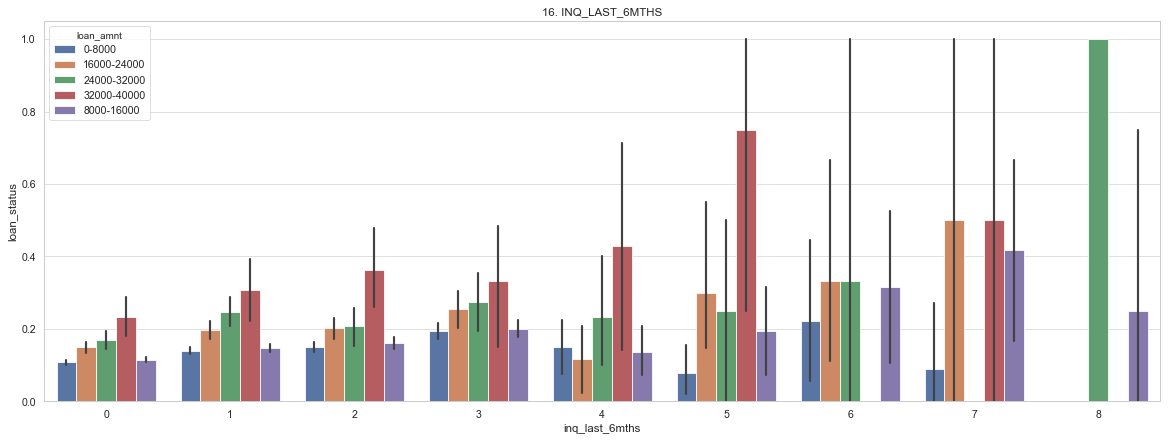

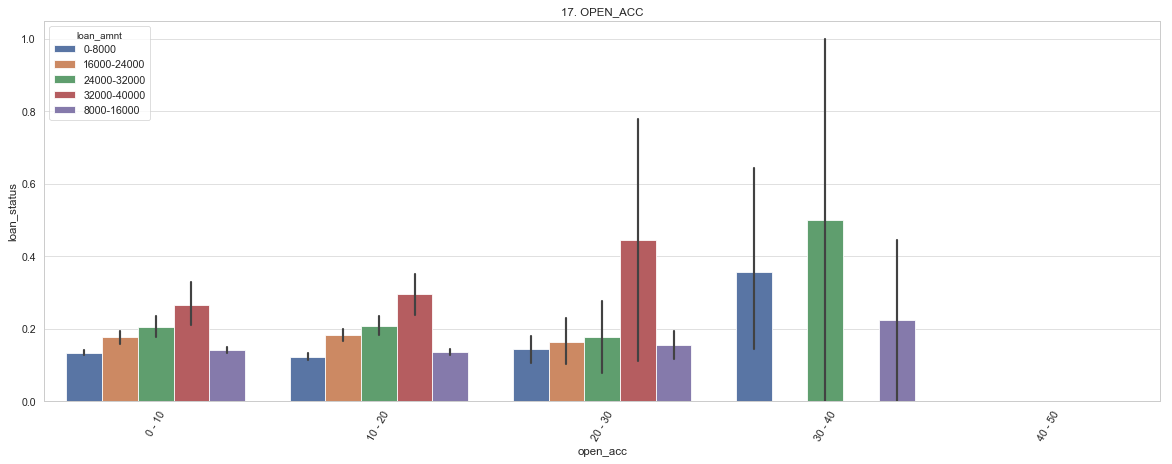

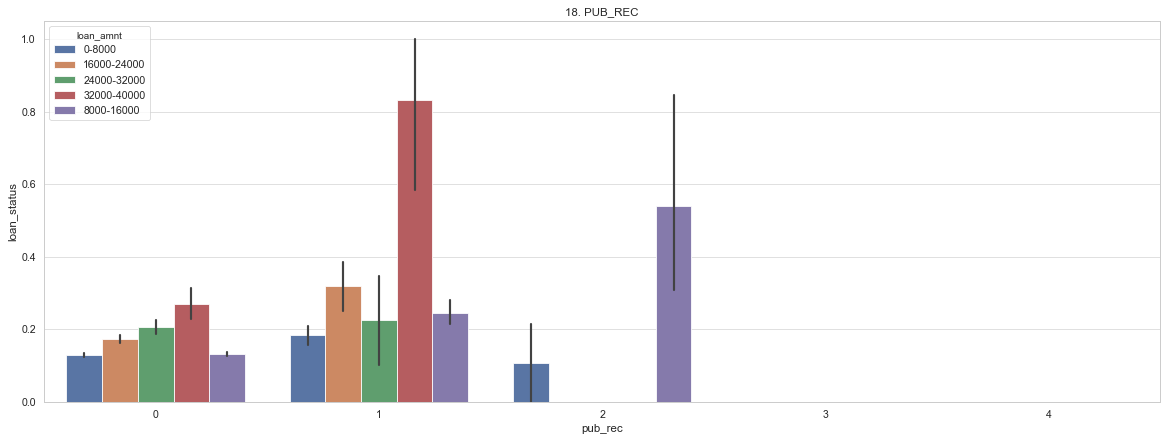

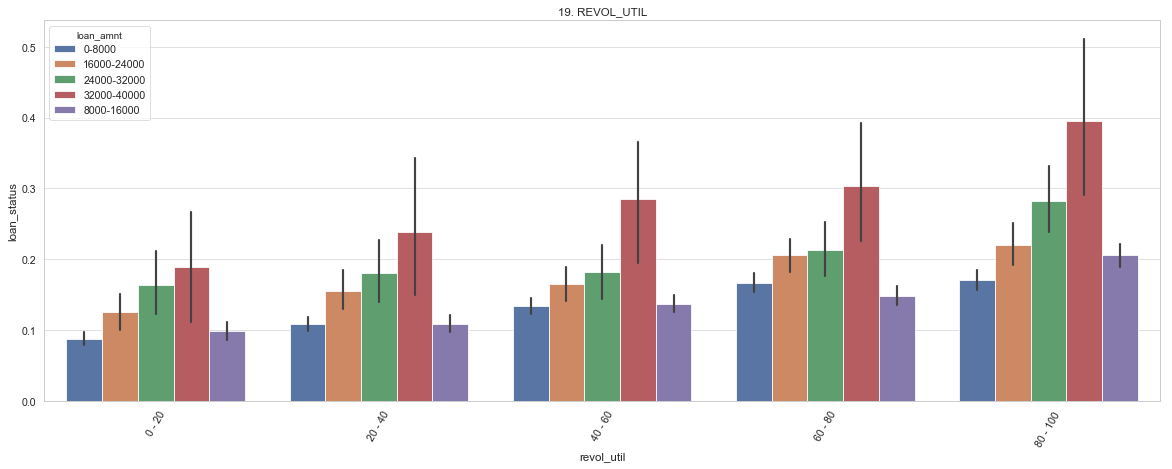

In [30]:
#Bivariate analysis of the quantitative/categorical variables against the loan purpose
category_list=['purpose','grade','loan_amnt']
for category_col in category_list:
    print('Bivariate analysis for ' + category_col.upper())
    print('='*120)
    columns_for_analysis=[]
    for col,value in {col:len(loan[col].unique()) for col in loan.columns}.items():
        span=5
        quantile=0
        if col=='sub_grade':
            continue
        else:
            if col=='annual_inc':
                quantile=0.05
            columns_for_analysis.append([plot.bar,True if value>20 else False,span,quantile,col,'loan_status',category_col])
    
    draw_multiple_plots(1,loan,columns_for_analysis,width=20,height=7)
    plt.show()

**Note : Though we have plotted the bivariate plots for the three attributes purpose, grade and amount, we are going to present some of the analysis of the purpose attribute only as the bivariate analysis as the other two attributes (grade and loan amount) mostly followed the same trends as was during the segmented univariate analysis.**

**Analysis form the above bivariate plots for loan purpose**

1. *The loans on which borrowers tend to default the most are given below.*
    * *Business Loans (28%)*
    * *Other Loans (16%)*
    * *Debt Consolidation (15%)*
    * *House Loans (13%)*
    * *Personal Loans (13%)*
    * *Car Loans (11%)*
    * *Credit Cards (11%)*
    * *Major Puchase (10%)*

2. *Borrowers with a loan amounts of 32,000 to 40,000 as Personal loans tend to default by almost 40% as compared to around 15% for those in other loan amount brackets, suggesting people with high amount of Personal loans tend to default a lot.*

3. *The default rate for Car loans is pretty high almost 22% for borrowers with loan amounts of 16,000 to 24,000 as compared to almost 10% in other loan amount brackets, suggesting that people with higher loan amounts as Car loans default twice as much as other amounts..*

3. *Nobody in the loan amounts of 24,000 to 40,000 has defaulted for Car loans, suggesting that the people avail for car loans mostly below 24,000.*

4. *Borrowers belonging to grades F & G having a Car loan tend to default by almost 30% more than those belonging to grades A, B, C or D, suggesting Car loans for these grades should be scrutinized more.*

5. *The personal loan in the grade G is almost 20% more than that in other grades, suggesting Personal loans are a bad investment in this grade.*

6. *Borrowers having Car loans with no information regarding their home ownership default by almost 50% as compared to 10% for those with information, suggesting these loans should be avoided. Also there are no defaults in the Major Purchases for these borrowers, suggesting these borrowers may not have any permanent dwelling.*

#### 5. Assumptions

1. *All the analysis has been done after having removed the loan records with status currently active or in progress.*

2. *The Loan amounts have been grouped into various brackets of 10,000 each.*

3. *The purpose of loans have been grouped into various categories as given below*
    * *DEBT_CONSOLIDATION*
    * *CREDIT_CARD*
    * *OTHER*
    * *MAJOR_PURCHASE*
    * *BUSINESS_LOANS consisting of SMALL_BUSINESS, RENEWABLE_ENERGY*
    * *CAR*
    * *HOUSE_LOANS consisting of HOME_IMPROVEMENT, HOUSE, MOVING*
    * *PERSONAL_LOANS consisting of WEDDING, MEDICAL, VACATION, EDUCATIONAL.*
    
4. *All the other numerical variables with unique elements more than 20 have been bracketed into 5 or 10 bins depending upon the type of analysis.*